In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import sklearn


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msgo

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)


In [3]:
from src.eda_utils import insert_note, load_notes, categorize_numeric

In [4]:
df = pd.read_csv('data/dados.csv', sep=';')

df = df.drop(columns=['Unnamed: 23', 'Legenda'])
print(df.shape)
df.head()

(299616, 23)


/home/jrcunha/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Dia semana agendamento,Ano agendamento,Mes agendamento,Hora agendamento,Dia mes agendamento,Dia semana atendimento,Ano atendimento,Mes atendimento,Hora atendimento,Dia mes atendimento,Secao,Medico preferencial,Renda Provavel,MicroArea,Diretoria,Cod convenio,Codigo exame,Idade,Tempo medio de agendamento,Unidade,Bairro,Feminino,No Show
0,6,2019,8,8,18,3,2019,8,15,15,110,0,1028823,377,7,115,465530,39,2,VILLA LOBOS,4218,1,0
1,2,2019,11,7,6,0,2019,11,13,4,110,0,1028823,377,7,115,465530,39,1,VILLA LOBOS,4218,1,1
2,5,2019,8,8,31,3,2019,8,15,15,36,0,1028823,377,7,115,465530,39,15,ITAIM,4218,1,0
3,4,2019,9,11,27,4,2019,9,8,27,110,1,489594,767,7,115,465530,49,0,HIGIENÓPOLIS,2169,1,0
4,4,2019,10,11,11,1,2019,10,17,1,110,0,31829,568,7,115,7244510,33,9,ALPHAVILLE,9638,1,0


* Show = 0
* No Show = 1

label = No Show

### Utils

In [6]:
def plot_hist_against_target(df, feature):
    
    fig, ax = plt.subplots()

    ax.hist(df.loc[df["no_show"]==1, feature], 
            bins=15, 
            alpha=0.5, 
            color="red", 
            label="No Show")

    ax.hist(df.loc[df["no_show"]==0, feature],
            bins=15, 
            alpha=0.5, 
            color="green", 
            label="Show")

    ax.set_xlabel(feature)
    ax.set_ylabel("# casos observados")

    fig.suptitle("%s vs No Show" % feature)

    ax.legend();
    
    
def plot_density_against_target(df, feature):
    fig, ax = plt.subplots()

    sns.kdeplot(df[df["no_show"]==1][feature], 
                shade=True, 
                color="blue", 
                label="Show", ax=ax)
    
    sns.kdeplot(df[df["no_show"]==0][feature], 
                shade=True, 
                color="green", 
                label="No Show", 
                ax=ax)

    ax.set_xlabel(feature)
    ax.set_ylabel("Density")

    fig.suptitle("%s vs No Show" % feature)
    
    ax.legend();
    
def remove_outliers(df_input, feature):
    
    df = df_input.copy()
    
    q1, q2, q3 = df[feature].quantile([0.25, 0.5, 0.75])
    IQR = q3 - q1
    chart = df[df[feature] < q2 + 1.5 *IQR]
    chart = df[df[feature] > q2 - 1.5 *IQR]
    
    return chart


### Initial Exploration

In [7]:
def format_col(col):
    return "_".join(col.split(' ')).lower()

columns = {col: format_col(col) for col in df.columns}
columns

{'Dia semana agendamento': 'dia_semana_agendamento',
 'Ano agendamento': 'ano_agendamento',
 'Mes agendamento': 'mes_agendamento',
 'Hora agendamento': 'hora_agendamento',
 'Dia mes agendamento': 'dia_mes_agendamento',
 'Dia semana atendimento': 'dia_semana_atendimento',
 'Ano atendimento': 'ano_atendimento',
 'Mes atendimento': 'mes_atendimento',
 'Hora atendimento': 'hora_atendimento',
 'Dia mes atendimento': 'dia_mes_atendimento',
 'Secao': 'secao',
 'Medico preferencial': 'medico_preferencial',
 'Renda Provavel': 'renda_provavel',
 'MicroArea': 'microarea',
 'Diretoria': 'diretoria',
 'Cod convenio': 'cod_convenio',
 'Codigo exame': 'codigo_exame',
 'Idade': 'idade',
 'Tempo medio de agendamento': 'tempo_medio_de_agendamento',
 'Unidade': 'unidade',
 'Bairro': 'bairro',
 'Feminino': 'feminino',
 'No Show': 'no_show'}

In [8]:
df.rename(columns=columns, inplace=True)

In [9]:
df.isna().mean()

dia_semana_agendamento        0.0
ano_agendamento               0.0
mes_agendamento               0.0
hora_agendamento              0.0
dia_mes_agendamento           0.0
dia_semana_atendimento        0.0
ano_atendimento               0.0
mes_atendimento               0.0
hora_atendimento              0.0
dia_mes_atendimento           0.0
secao                         0.0
medico_preferencial           0.0
renda_provavel                0.0
microarea                     0.0
diretoria                     0.0
cod_convenio                  0.0
codigo_exame                  0.0
idade                         0.0
tempo_medio_de_agendamento    0.0
unidade                       0.0
bairro                        0.0
feminino                      0.0
no_show                       0.0
dtype: float64

0    0.881058
1    0.118942
Name: no_show, dtype: float64


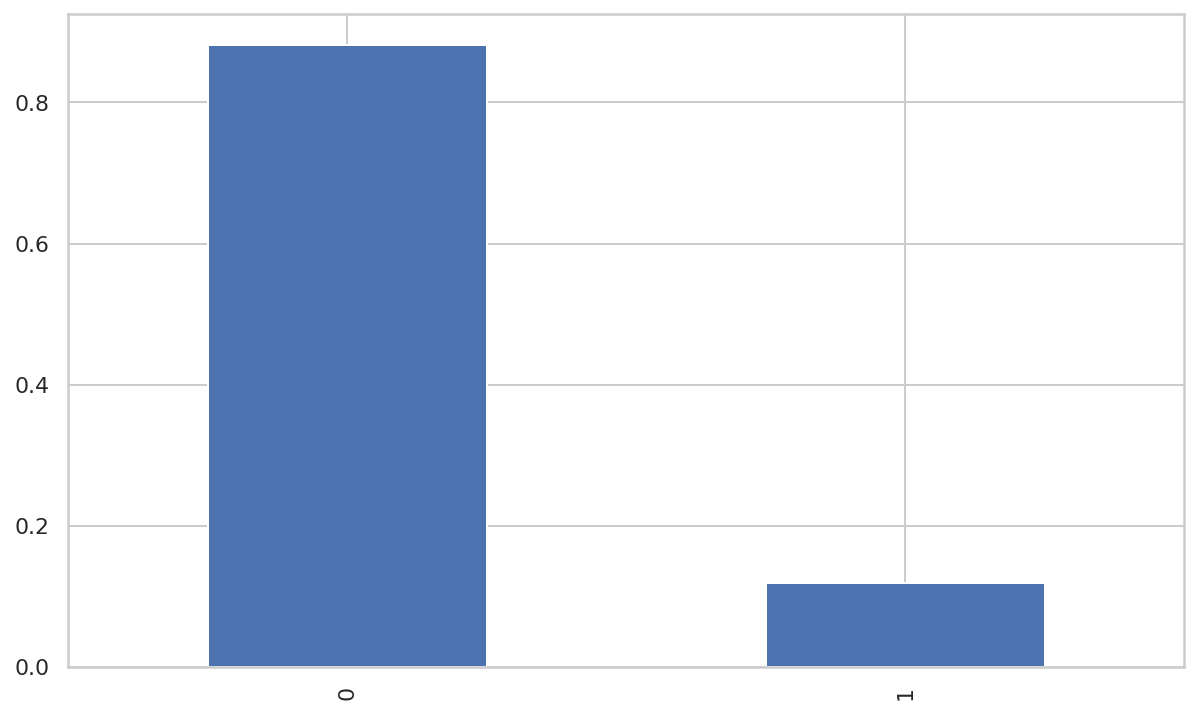

In [10]:
chart = df['no_show'].value_counts(normalize=True)
print(chart)
chart.plot(kind='bar');

In [11]:
# insert_note('12% dos pacientes não comparecem')

In [12]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(299616, 23)
(252719, 23)


In [13]:
for col in df.columns:
    uniques = df[col].unique()
    print(col,':', len(uniques))
    print(uniques[:10])
    print()

dia_semana_agendamento : 7
[6 2 5 4 1 0 3]

ano_agendamento : 1
[2019]

mes_agendamento : 4
[ 8 11  9 10]

hora_agendamento : 19
[ 8  7 11 15 14 13 17 10  9 12]

dia_mes_agendamento : 31
[18  6 31 27 11 25 19 15 21 24]

dia_semana_atendimento : 7
[3 0 4 1 2 6 5]

ano_atendimento : 1
[2019]

mes_atendimento : 7
[ 8 11  9 10  7  6  5]

hora_atendimento : 19
[15 13  8 17 14 10 12 16  6 20]

dia_mes_atendimento : 31
[15  4 27  1 11 18  9 14 21 28]

secao : 32
[110  36  96 240 120  68  98 104  22  46]

medico_preferencial : 2
[0 1]

renda_provavel : 27421
[1028823  489594   31829 1594189 3249315 1963578 6532823 3388621 4145087
 2343396]

microarea : 573
[377 767 568   3 321 315 202 498 183 638]

diretoria : 2
[7 6]

cod_convenio : 86
[  115    30 12710   385   120   350     0 29525   360   860]

codigo_exame : 457
[ 465530 7244510 4386980  102700 4317950 2244580 4728620 2244710 6287970
    8970]

idade : 105
[39 49 33 44 87 41 54 60 42 43]

tempo_medio_de_agendamento : 91
[ 2  1 15  0  9 14

In [14]:
df.columns

Index(['dia_semana_agendamento', 'ano_agendamento', 'mes_agendamento',
       'hora_agendamento', 'dia_mes_agendamento', 'dia_semana_atendimento',
       'ano_atendimento', 'mes_atendimento', 'hora_atendimento',
       'dia_mes_atendimento', 'secao', 'medico_preferencial', 'renda_provavel',
       'microarea', 'diretoria', 'cod_convenio', 'codigo_exame', 'idade',
       'tempo_medio_de_agendamento', 'unidade', 'bairro', 'feminino',
       'no_show'],
      dtype='object')

In [15]:
numericals = ['renda_provavel', 'idade', 'tempo_medio_de_agendamento']

categoricals = ['dia_semana_agendamento', 'ano_agendamento', 'mes_agendamento', 
                'hora_agendamento', 'dia_mes_agendamento', 'dia_semana_atendimento', 'ano_atendimento',
                'mes_atendimento', 'hora_atendimento', 'dia_mes_atendimento', 'secao', 
                'medico_preferencial', 'microarea', 'diretoria', 'cod_convenio', 'codigo_exame', 
                'unidade', 'bairro', 'feminino']


In [16]:
df[numericals].describe().T[['count', 'mean', 'std', 'min', 'max']].apply(lambda x: round(x, 2))

,count,mean,std,min,max
renda_provavel,252719.0,2285011.59,1969200.87,0.0,25317623.0
idade,252719.0,46.70,19.66,0.0,999.0
tempo_medio_de_agendamento,252719.0,5.44,6.35,-2.0,97.0


### tempo_medio_de_agendamento

In [18]:
df.loc[df['tempo_medio_de_agendamento'] < 0, 'no_show'].value_counts(normalize=True)

0    0.886598
1    0.113402
Name: no_show, dtype: float64

In [19]:
df = df.query('tempo_medio_de_agendamento > 0')

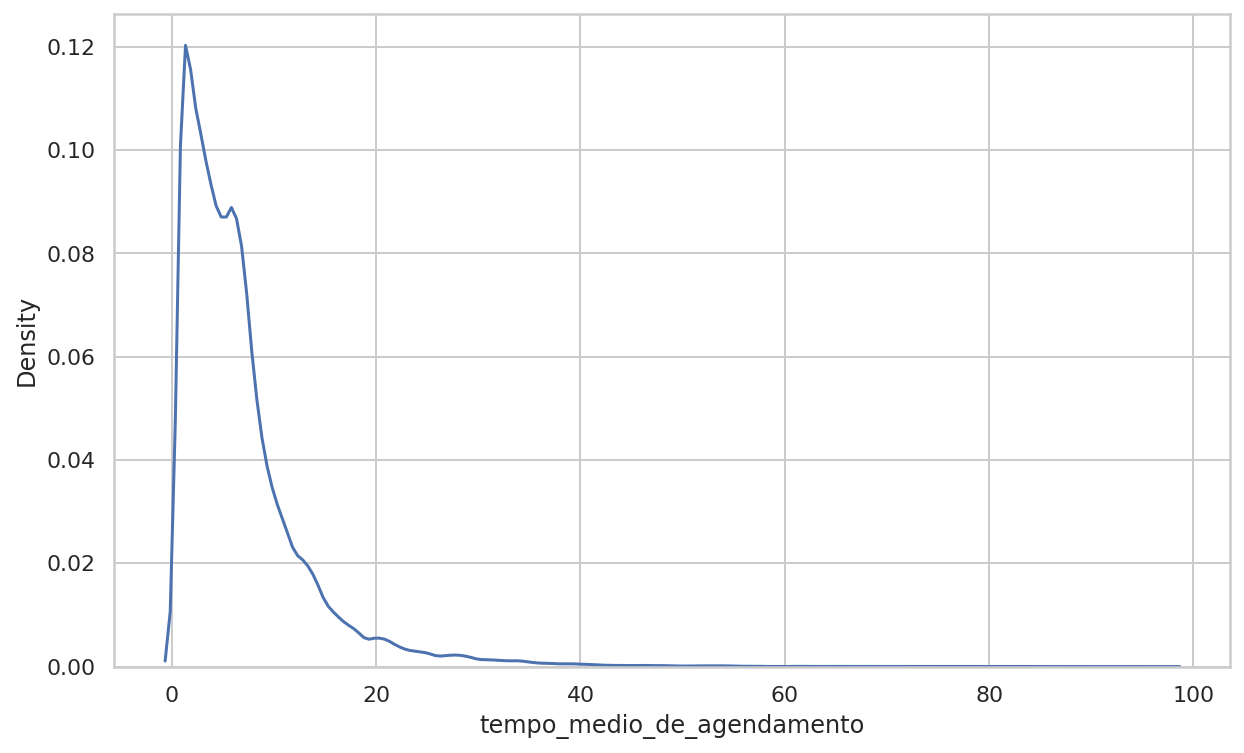

In [20]:
sns.kdeplot(df['tempo_medio_de_agendamento']);

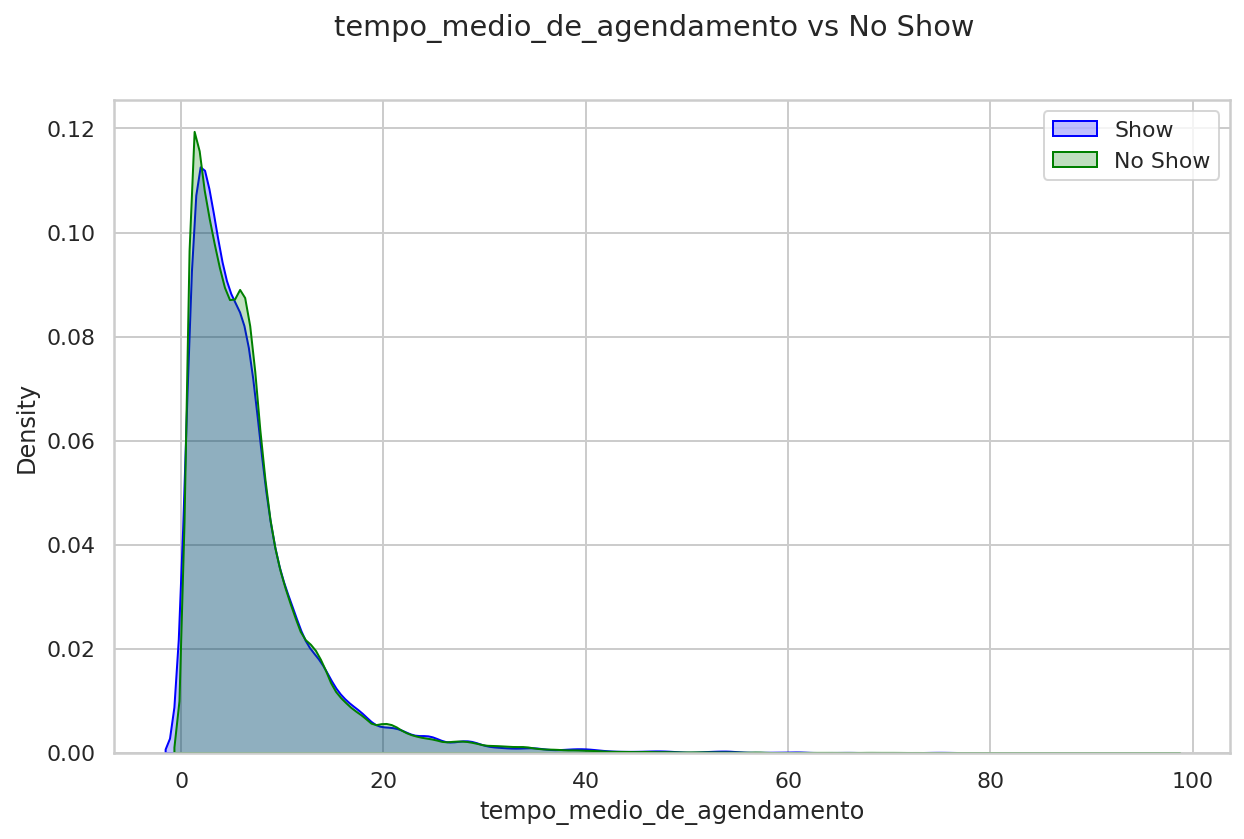

In [35]:
feature = 'tempo_medio_de_agendamento'
plot_density_against_target(df, feature)

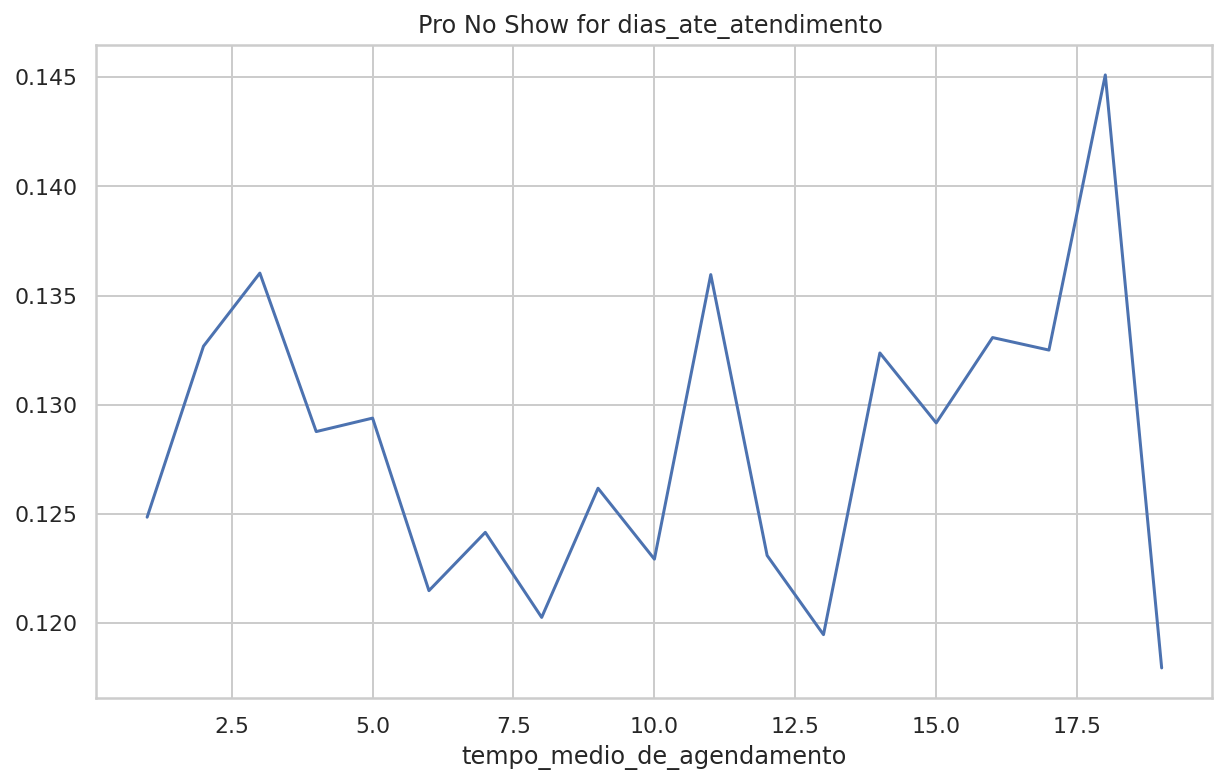

In [146]:
chart = df.query('tempo_medio_de_agendamento < 20')
chart.groupby('tempo_medio_de_agendamento')['no_show'].mean().plot()
plt.title("Pro No Show for %s " % feature);

### Idade

In [126]:
# insert_note('Os mais jovens tendem a faltar mais as consultas, embora a diferença de idade não seja tanta')
# insert_note('O sábado costuma ter maisno show')
# insert_note('Quando o médico é preferencial há menos No Show, independente da idade. Quando não é preferencial, os mais jovens tendem a faltar mais')
# insert_note('Se o exame é de imagem, há menos faltas, independentemente da idade. Se não é, os mais jovens faltam mais.')
# insert_note("independente da idade, o sexo não influencia no No show")

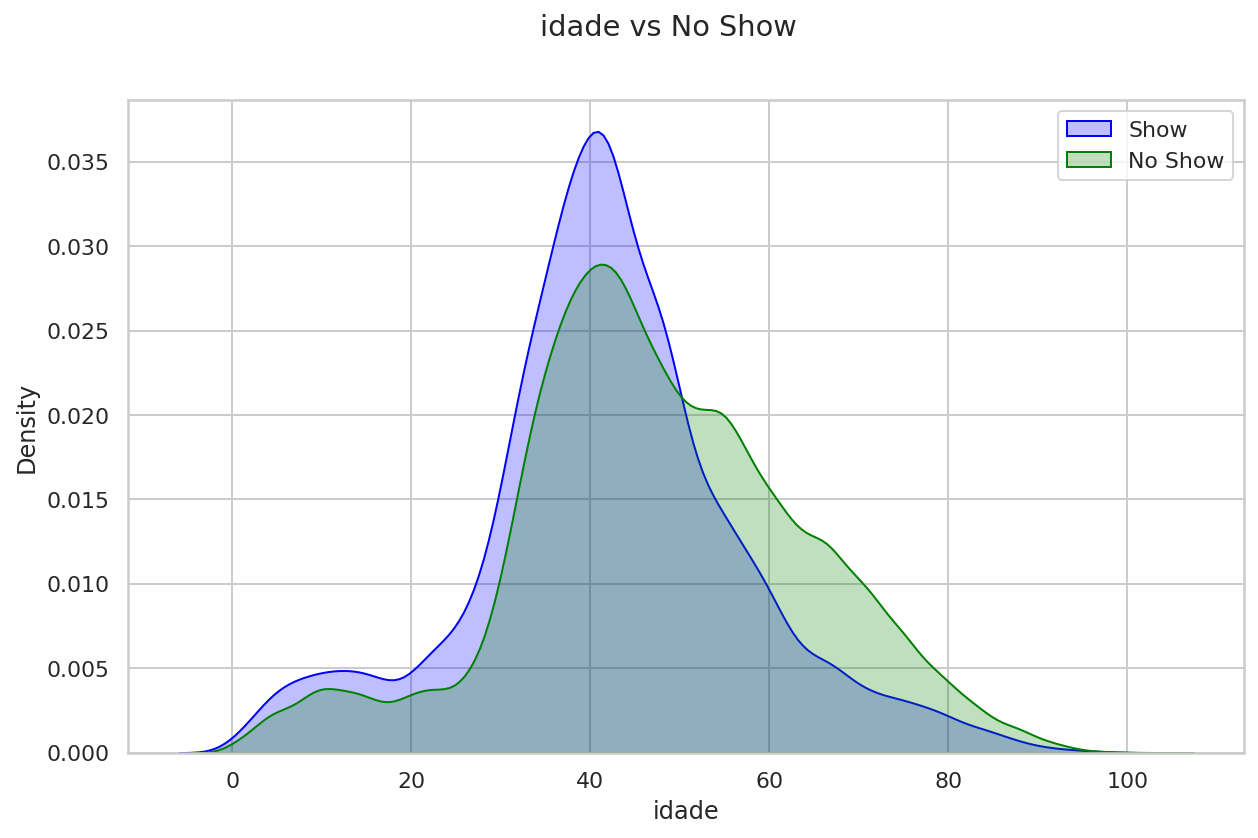

In [37]:
feature = 'idade'
df = df.query('idade < 150')
plot_density_against_target(df, feature)

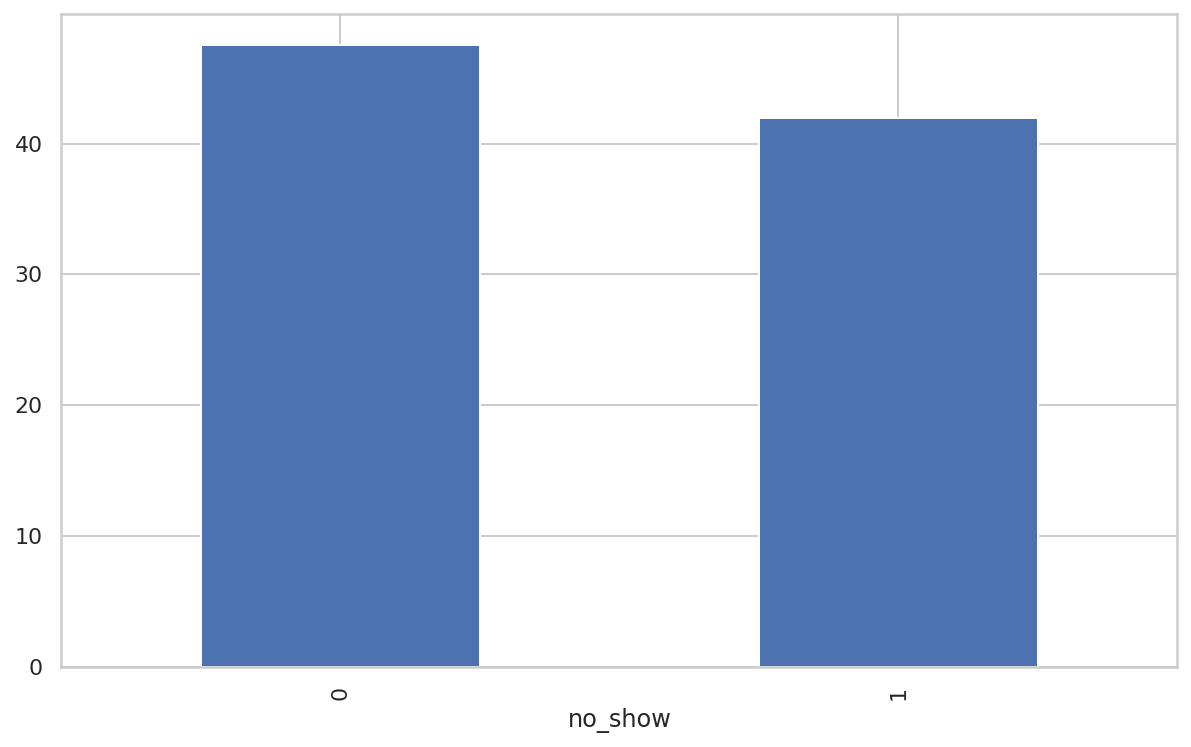

In [38]:
df.groupby('no_show')['idade'].mean().plot(kind='bar');

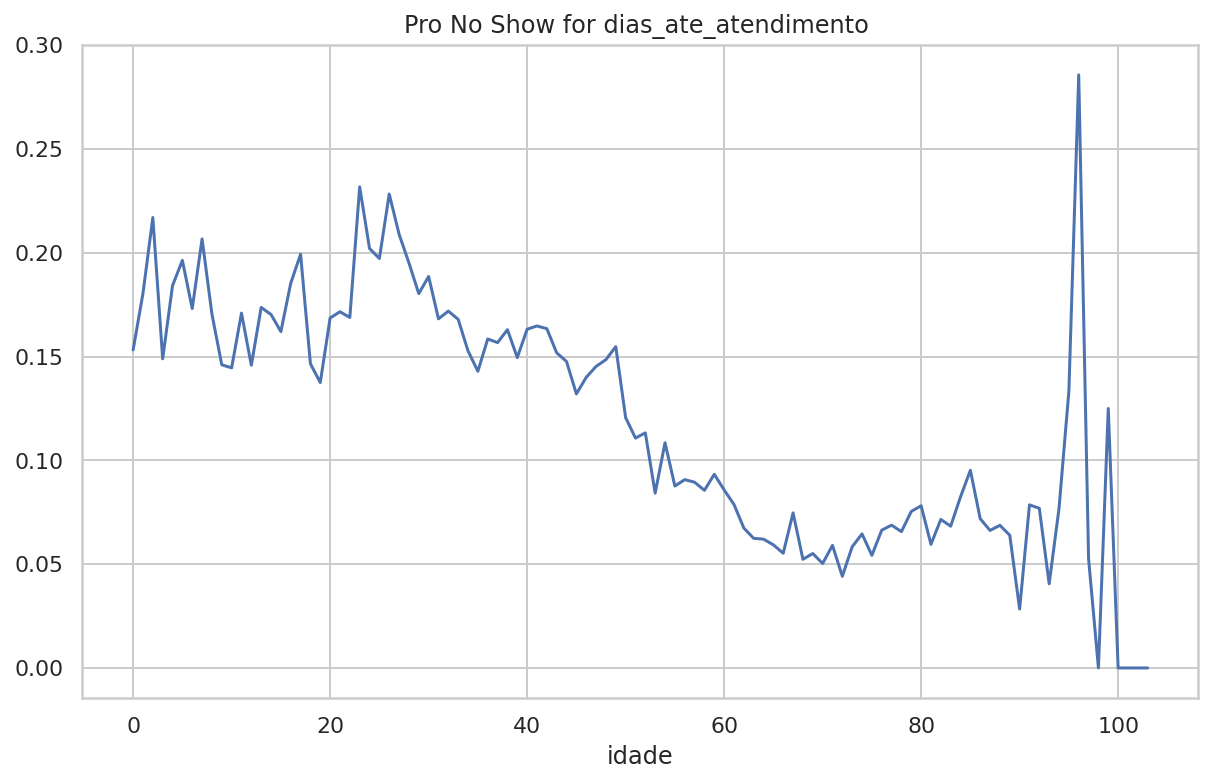

In [148]:
chart = remove_outliers(df, feature)
chart.groupby('idade')['no_show'].mean().plot()
plt.title("Pro No Show for %s " % feature);

Os mais jóvens costumam faltar mais aos exames

### Renda provavel

In [149]:
df['renda_provavel']  = df['renda_provavel'] / 1000
df = df.query('renda_provavel > 0')

In [150]:
feature = 'renda_provavel'
chart = remove_outliers(df, feature)

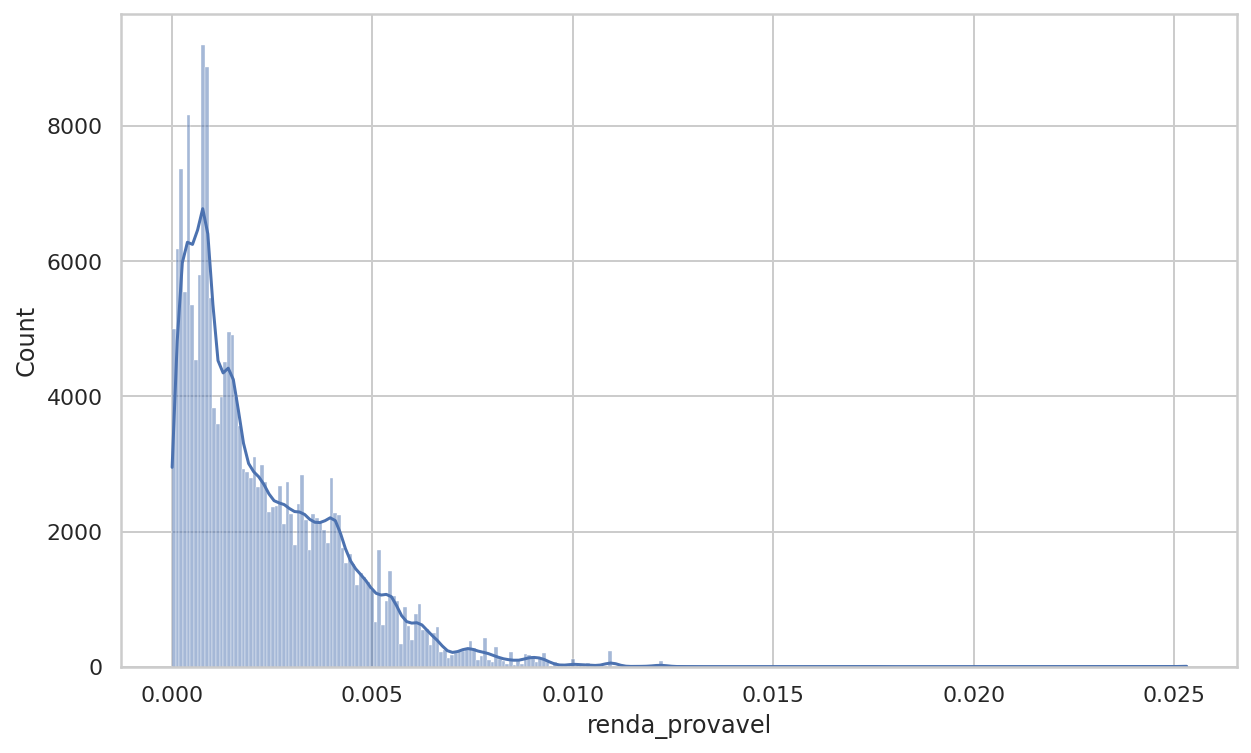

In [151]:
sns.histplot(chart['renda_provavel'], kde=True);

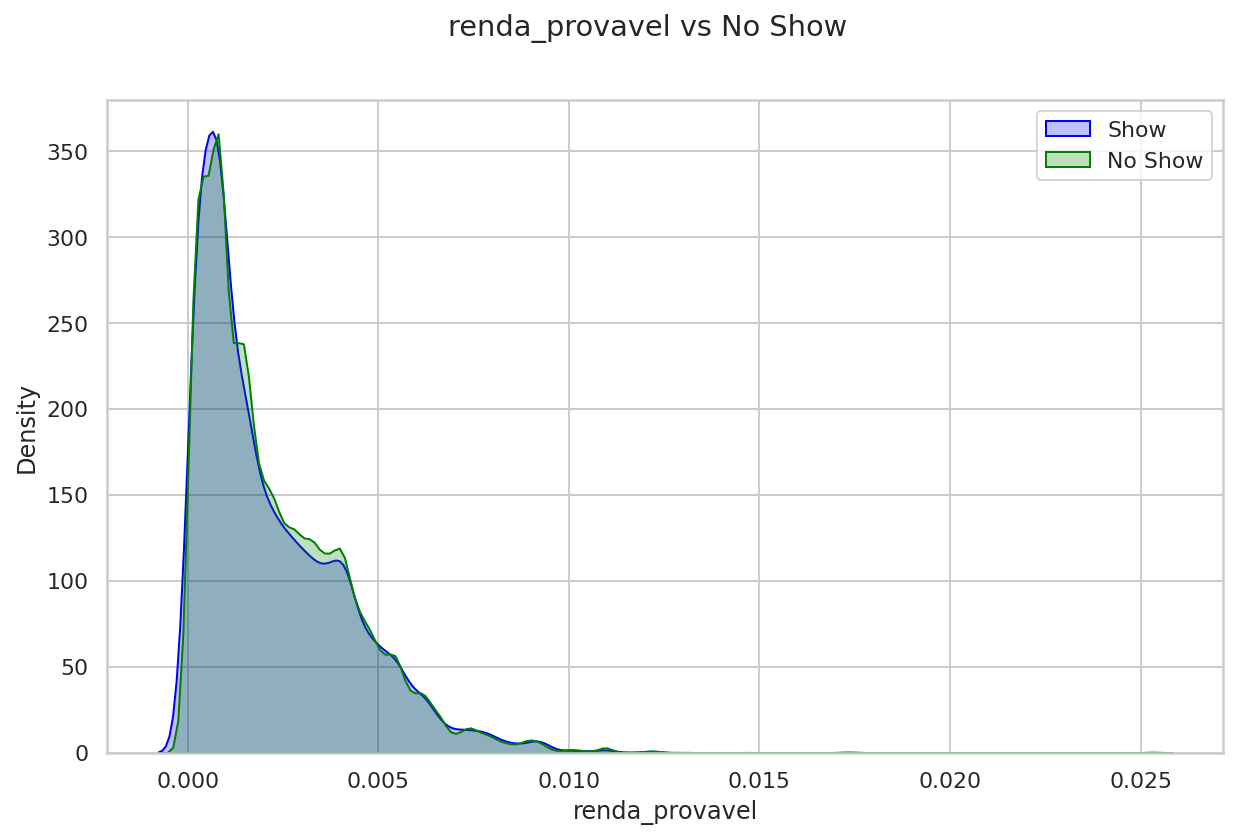

In [152]:
plot_density_against_target(chart, feature)

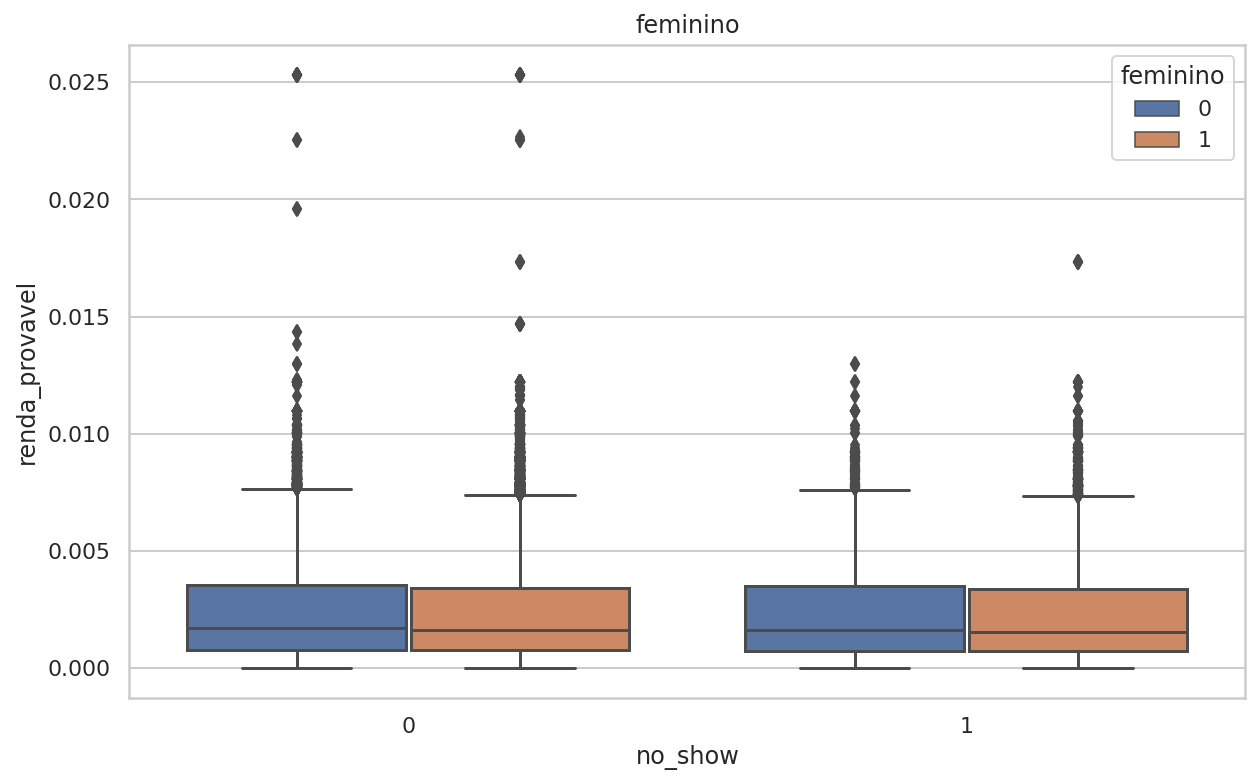

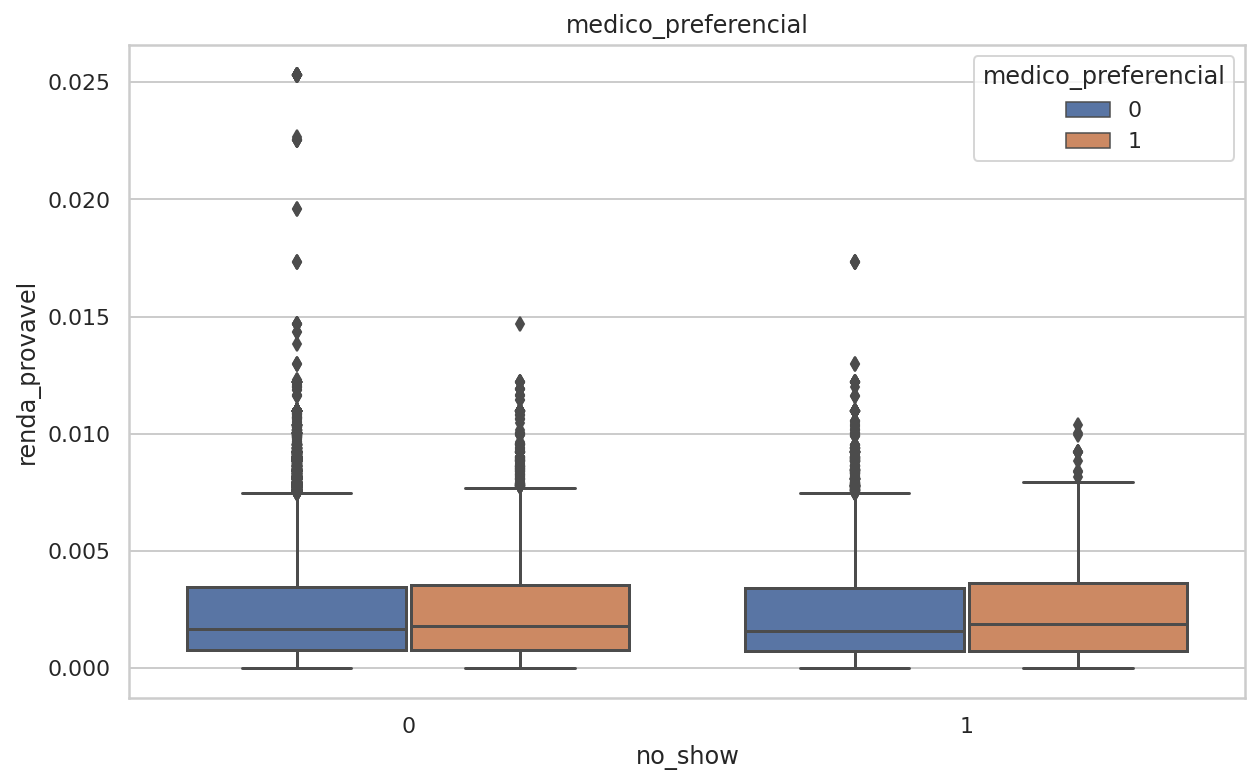

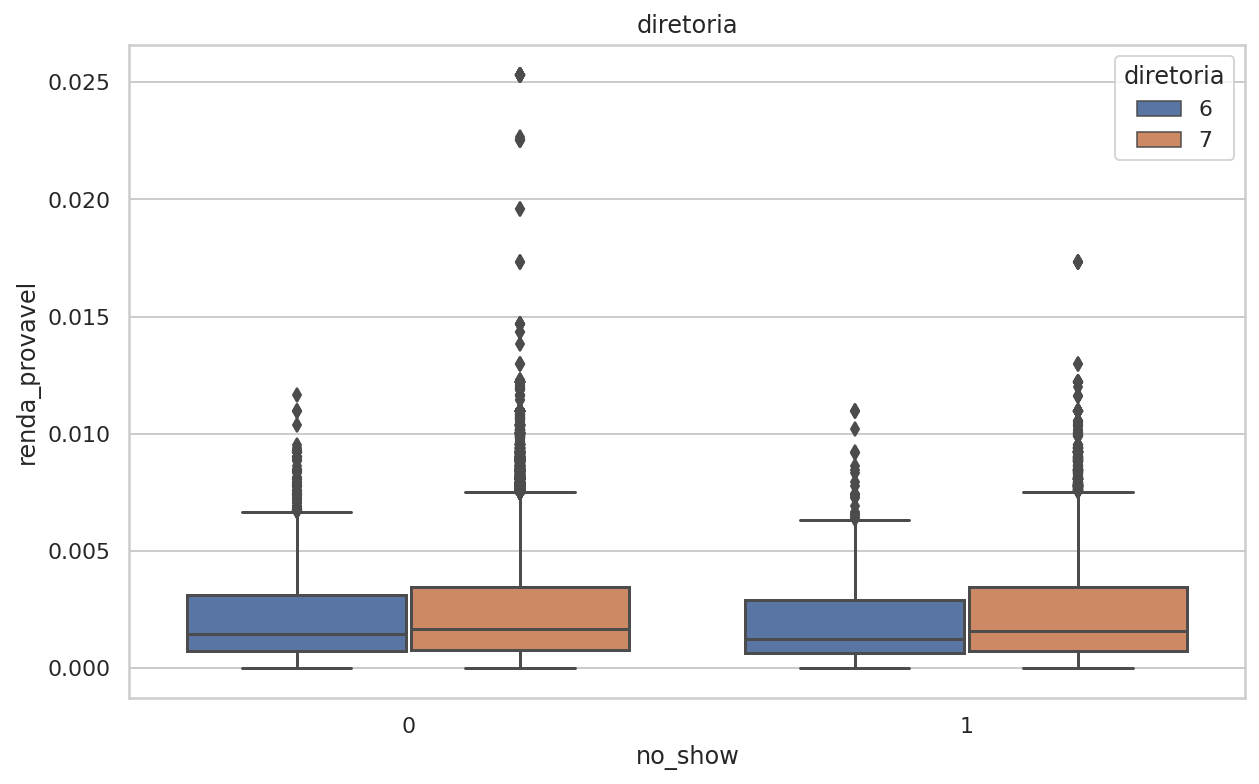

In [153]:
for col in ['feminino','medico_preferencial', 'diretoria']:
    plt.figure()
    sns.boxplot(x='no_show', y='renda_provavel', hue=col, data=chart)
    plt.title(col);

renda provavel não parece influenciar no No show

## Categoricals

In [142]:
print(categoricals)

['dia_semana_agendamento', 'ano_agendamento', 'mes_agendamento', 'hora_agendamento', 'dia_mes_agendamento', 'dia_semana_atendimento', 'ano_atendimento', 'mes_atendimento', 'hora_atendimento', 'dia_mes_atendimento', 'secao', 'medico_preferencial', 'microarea', 'diretoria', 'cod_convenio', 'codigo_exame', 'unidade', 'bairro', 'feminino']


In [78]:
from matplotlib.patches import Patch

def plot_prob_categorical(df, col, sort=False):    
    
    chart = df.groupby(col)['no_show'].mean()
    
    if sort:
        chart.sort_values(ascending=False, inplace=True)
    
    chart.plot(kind='bar')
    
    plt.hlines(y=df['no_show'].mean(), 
               xmin=-1, 
               xmax=1000, 
               color='red', 
               linestyles='dashed', 
               label='General No Show prob')
    plt.legend();
    plt.title('Prob No Show for %s' % col)
    

def catplot(df, feature):
    fig, ax = plt.subplots()
    
    sns.catplot(x=feature, hue="no_show", data=df, kind="count", ax=ax)
    # palette={1:"red", 0:"green"}, 

    plt.close(1) 

    ax.set_xlabel(feature)

    color_patches = [
        Patch(facecolor="red", label="No Show"),
        Patch(facecolor="green", label="Show")]
    
    ax.legend(handles=color_patches)

    fig.suptitle("%s vs. No Show" % feature)
    
def plot_categorical_by_target(df, feature):
    
    fig, ax = plt.subplots()

    sns.catplot(x="no_show", 
                hue=feature, 
                data=df, 
                kind="count", 
                ax=ax)

    plt.close(1) 

    ax.legend(title=feature)
#     ax.set_xticklabels(["Show", "NO Show"])
    ax.set_xlabel("")

    fig.suptitle("%s vs No Show");
    
    
def plot_stacked_bar(df, feature):
    
    counts_df = df.groupby([feature, "no_show"])["no_show"].count().unstack()    
    percents_df = counts_df.T.div(counts_df.T.sum()).T
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    percents_df.plot(kind="bar", stacked=True, ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel("Proportion")    
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    percents_df = counts_df.div(counts_df.sum()).T
    percents_df.plot(kind="bar", stacked=True, ax=ax)
    
    ax.legend(title=feature)
    ax.set_xticklabels(["Show", "No Show"], rotation=0)
    ax.set_xlabel("")
    ax.set_ylabel("Proportion")
    
    fig.suptitle("%s vs. No Show" % feature);

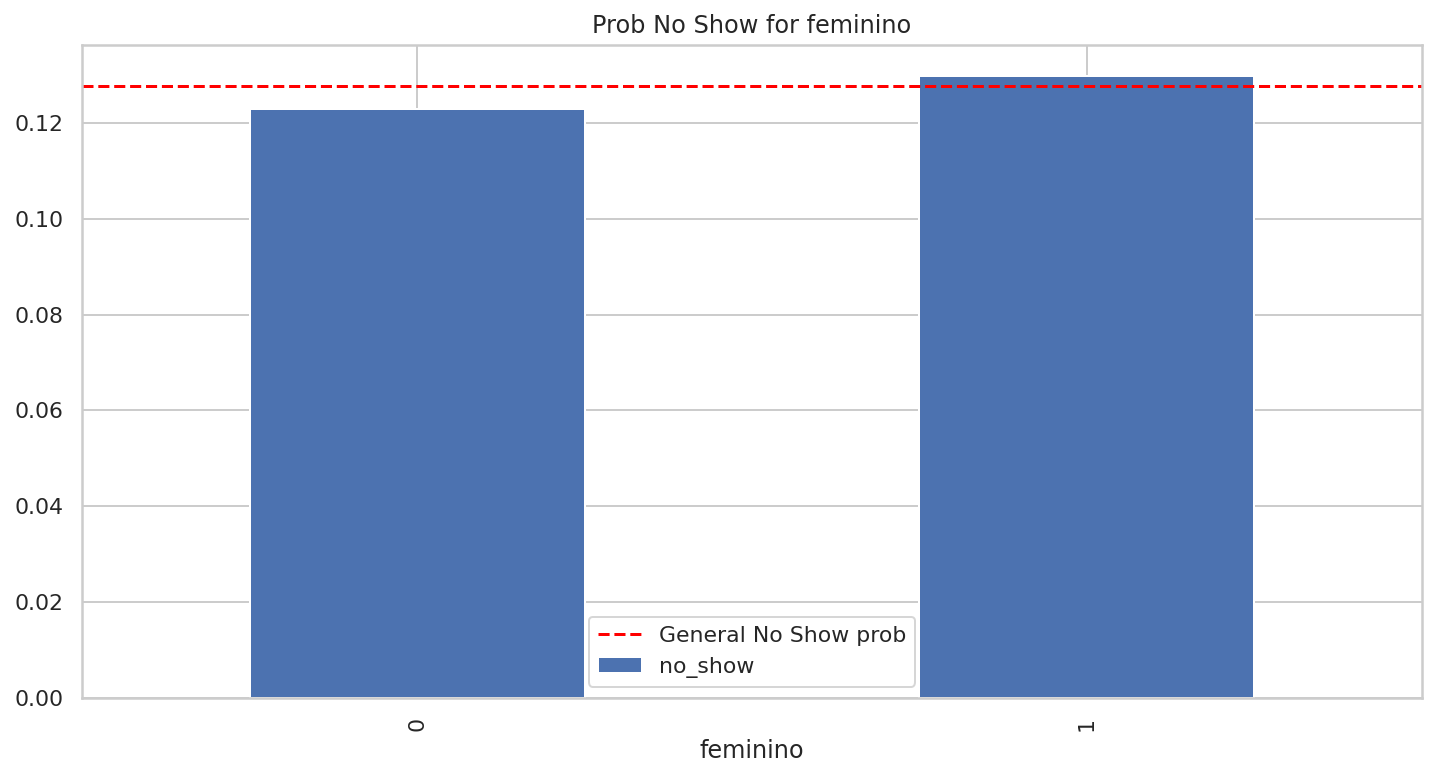

In [72]:
col = 'feminino'
plt.figure(figsize=(12, 6))

plot_prob_categorical(df,  col)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


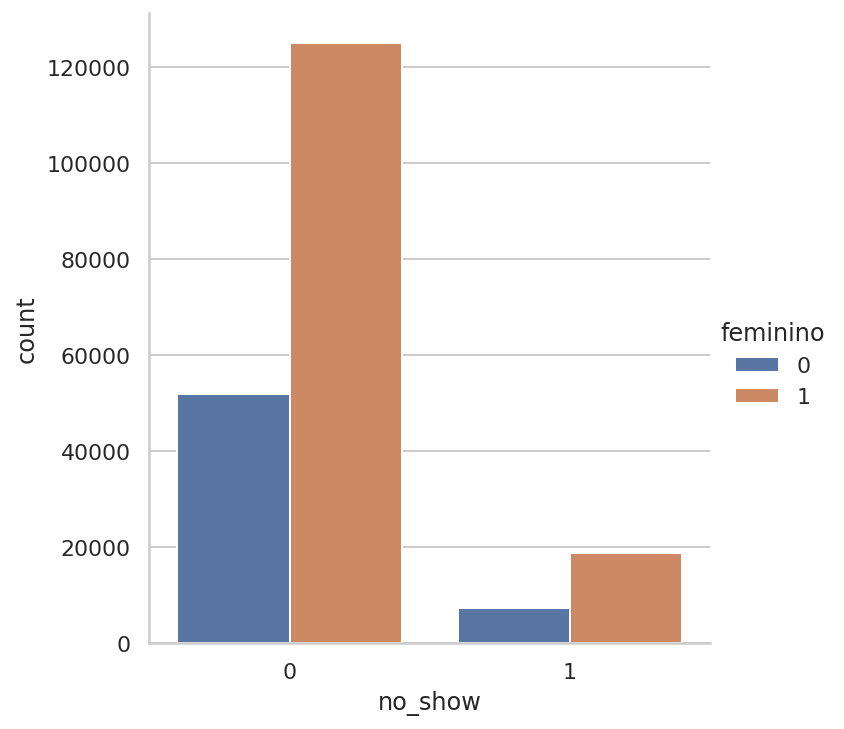

In [73]:
plot_categorical_by_target(df, col)

### Diretoria

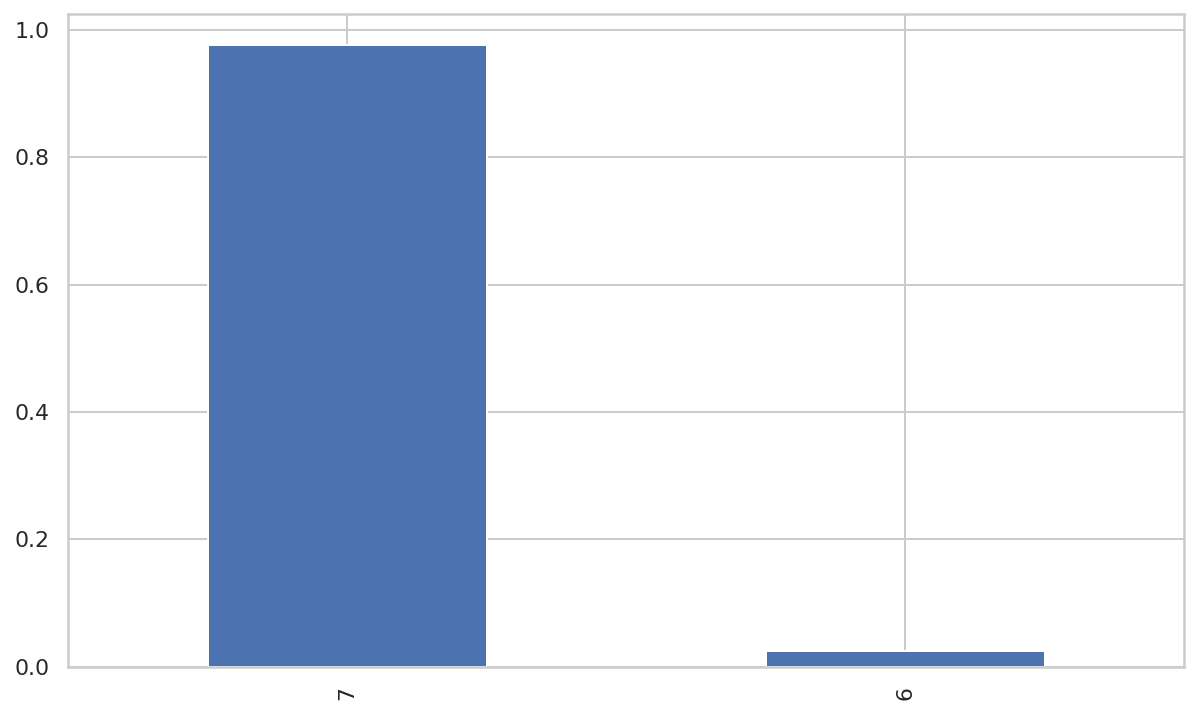

In [144]:
df['diretoria'].value_counts(normalize=True).plot(kind='bar');

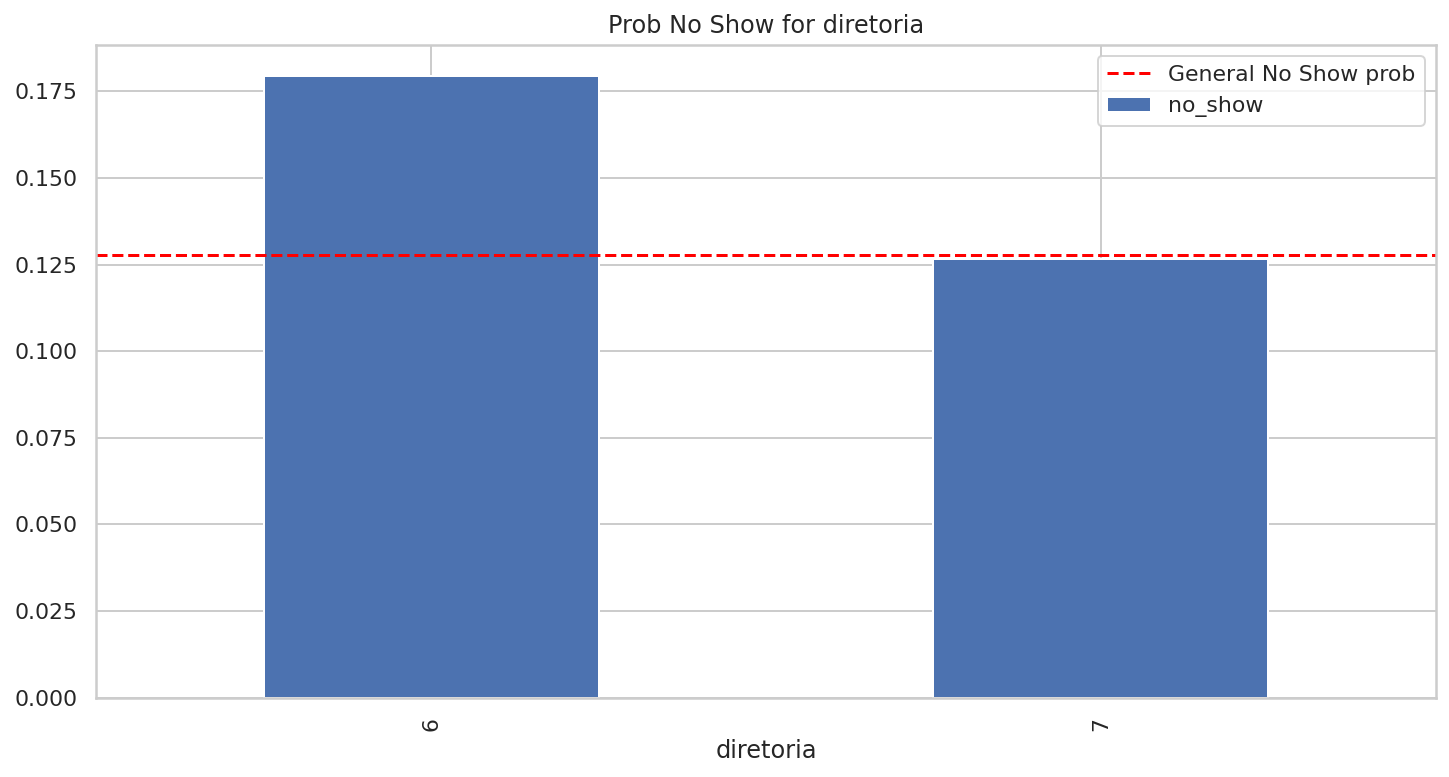

In [145]:
col = 'diretoria'
plt.figure(figsize=(12, 6))

plot_prob_categorical(df,  col)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


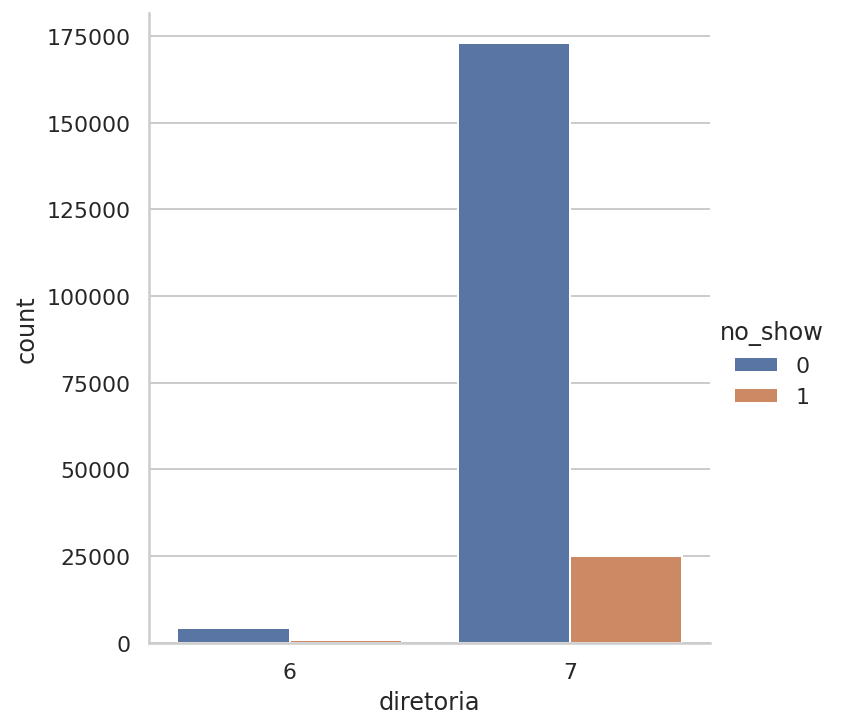

In [151]:
catplot(df, col)

Exames de imagem costumam ter menos No Show

### medico preferencial

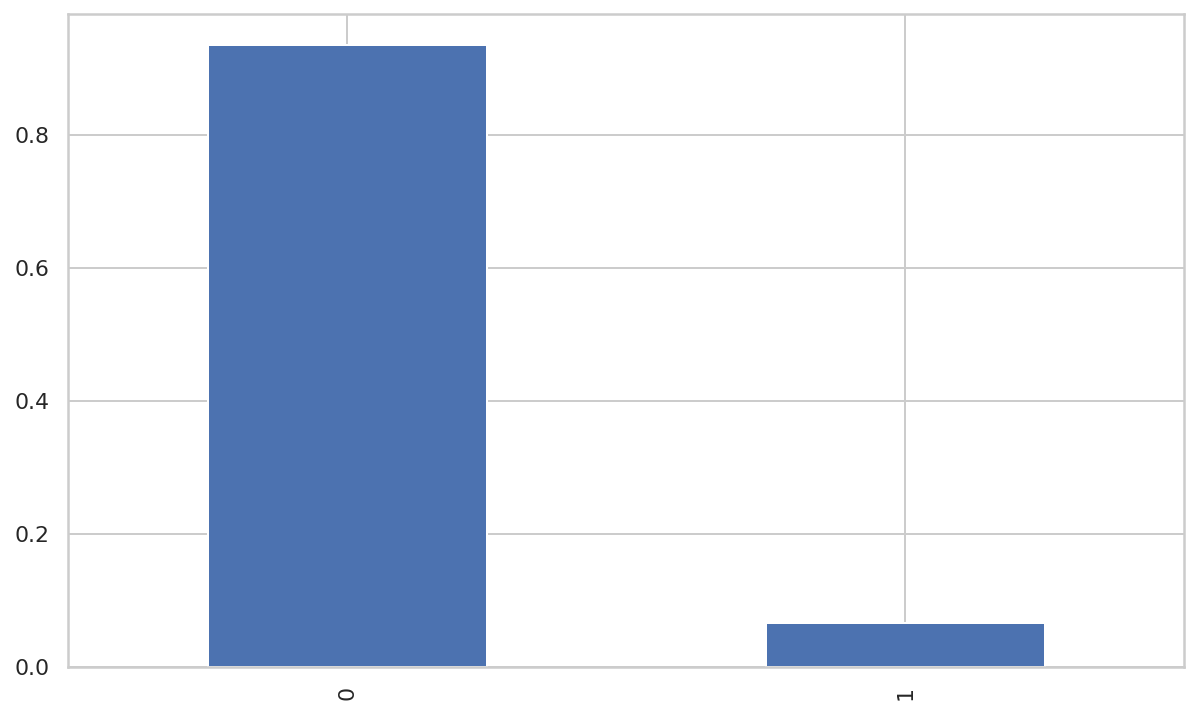

In [59]:
df['medico_preferencial'].value_counts(normalize=True).plot(kind='bar');

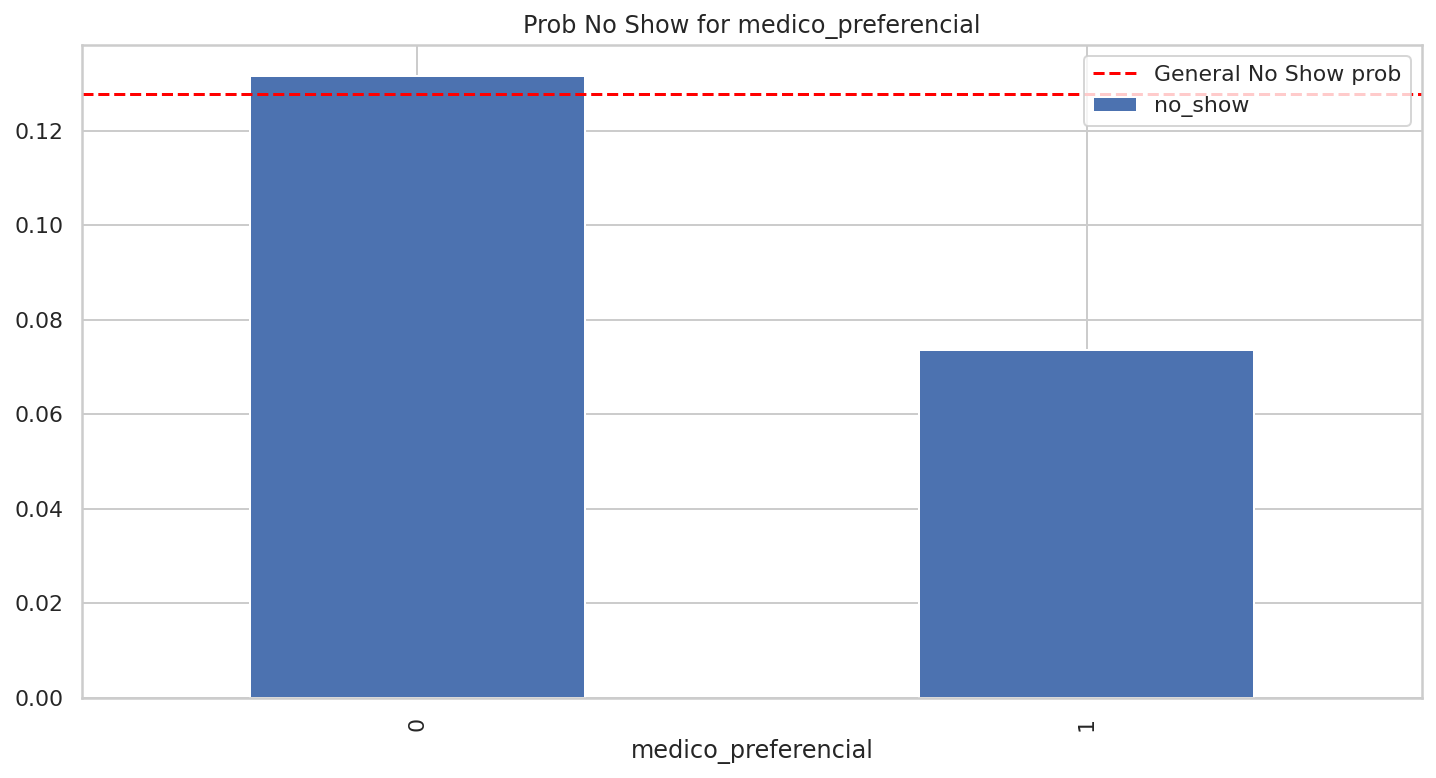

In [60]:
col = 'medico_preferencial'
plt.figure(figsize=(12, 6))

plot_prob_categorical(df,  col)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


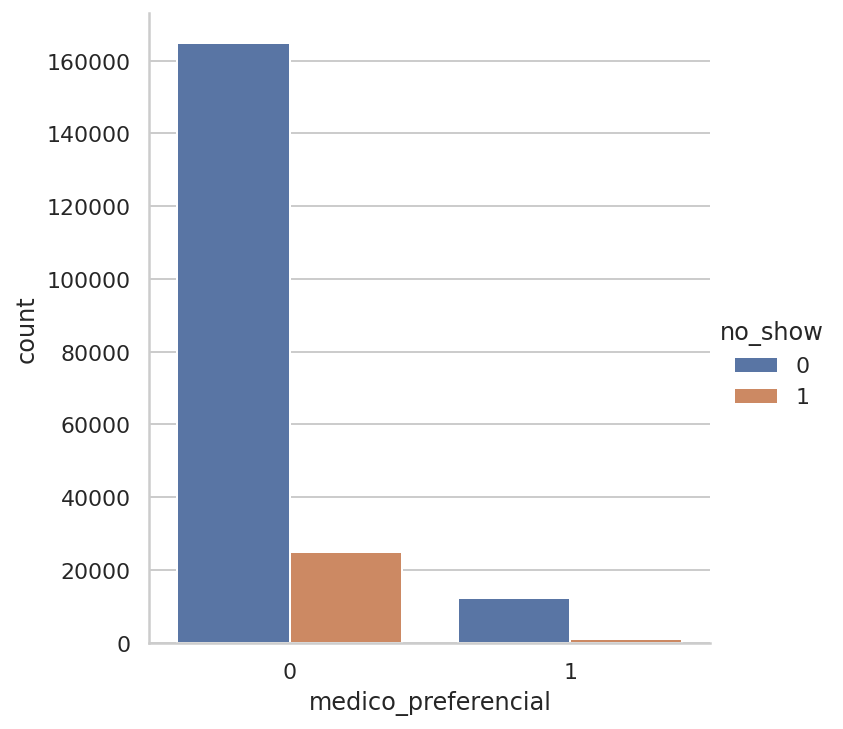

In [156]:
catplot(df, col)

quando o médico é preferencial, há uma significativa redução do no show

### Unidade

In [63]:
df['unidade'].value_counts(normalize=False)

PARAÍSO                       37005
R LÍBANO I                    17090
ITAIM                         17074
HIGIENÓPOLIS                  14069
ALPHAVILLE                    12203
ROCHAVERÁ                      9247
PONTE ESTAIADA                 8556
BRASIL II                      8420
VILLA LOBOS                    8264
CAMPO BELO                     8252
R LÍBANO II                    7722
BRAZ LEME                      7568
R LÍBANO III                   7337
ANÁLIA FRANCO II               7148
CAMPINAS                       5415
MORUMBI                        5258
SANTO ANDRÉ                    4777
SUMARÉ                         3400
SANTO ANDRÉ II                 2716
ANÁLIA FRANCO I (SHOPPING)     2524
VILA LEOPOLDINA                1981
SHOPPING JARDIM SUL            1854
JUNDIAÍ                        1359
GRANJA VIANA                   1059
BRASIL I                        752
SÃO BERNARDO DO CAMPO           423
SÃO CAETANO DO SUL              419
JAÚ                         

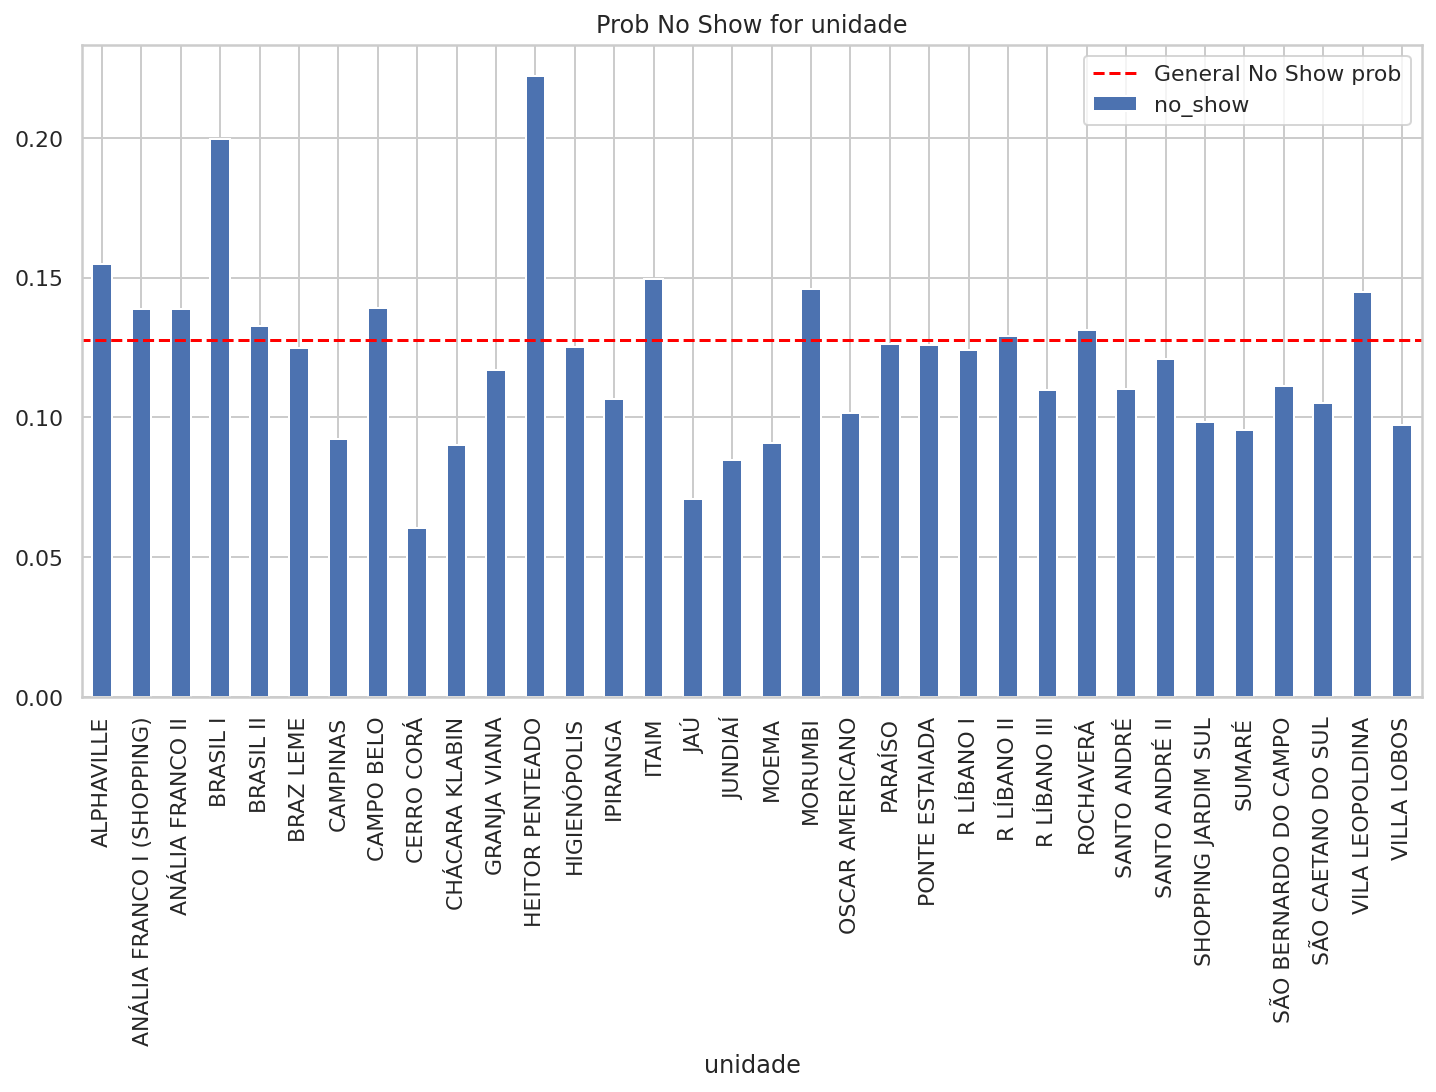

In [74]:
col = 'unidade'
plt.figure(figsize=(12, 6))

plot_prob_categorical(df,  col)

### Codigo convenio

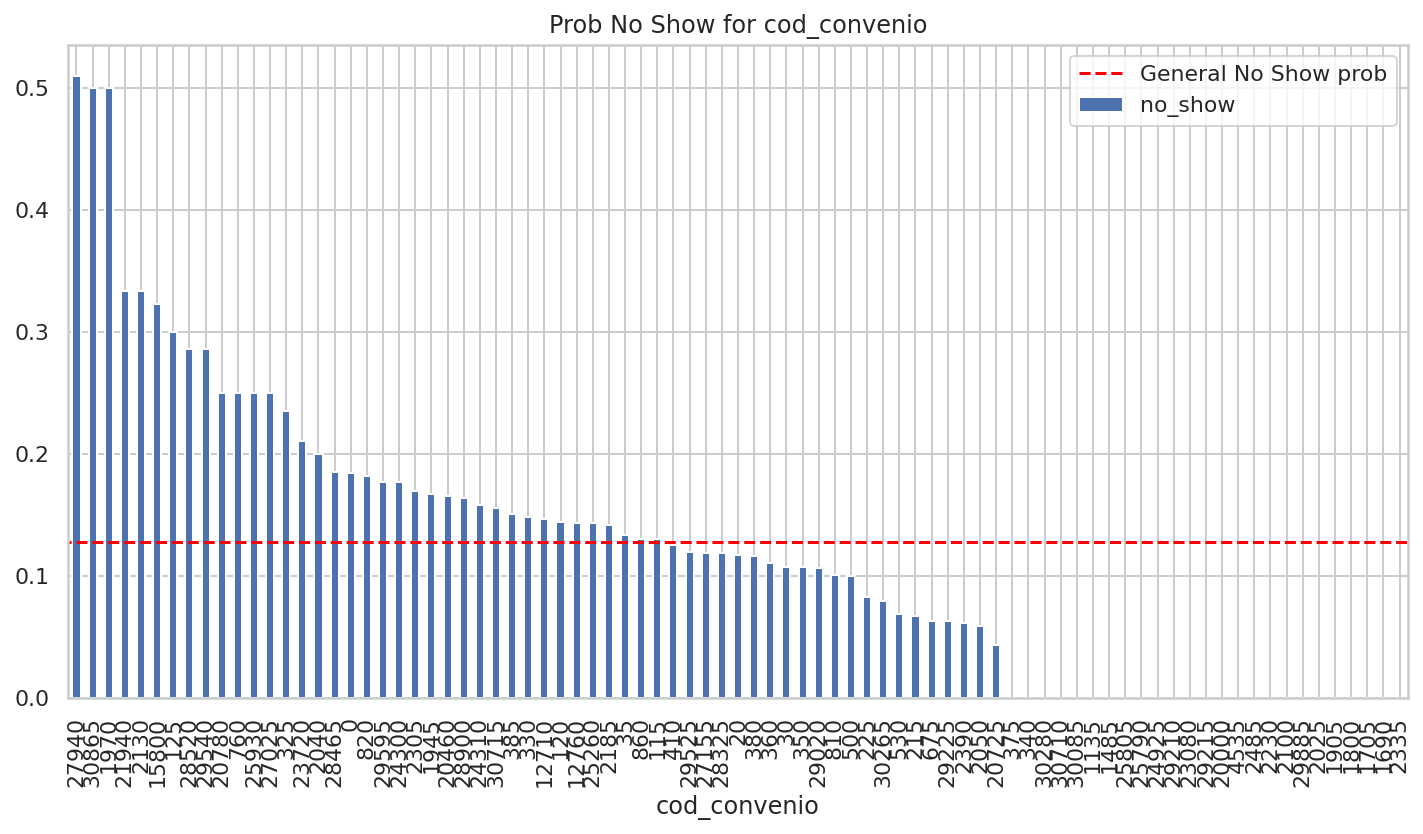

In [80]:
col = 'cod_convenio'
plt.figure(figsize=(12, 6))

plot_prob_categorical(df,  col, sort=True)

### Renda provável

In [83]:
df.loc[:, 'renda_provavel_cat'] = categorize_numeric(df, 'renda_provavel', n_bins=5)

In [85]:
df['renda_provavel_cat'].value_counts()

0-5      183507
5-10      18795
10-15       493
20-25        27
15-20        10
Name: renda_provavel_cat, dtype: int64

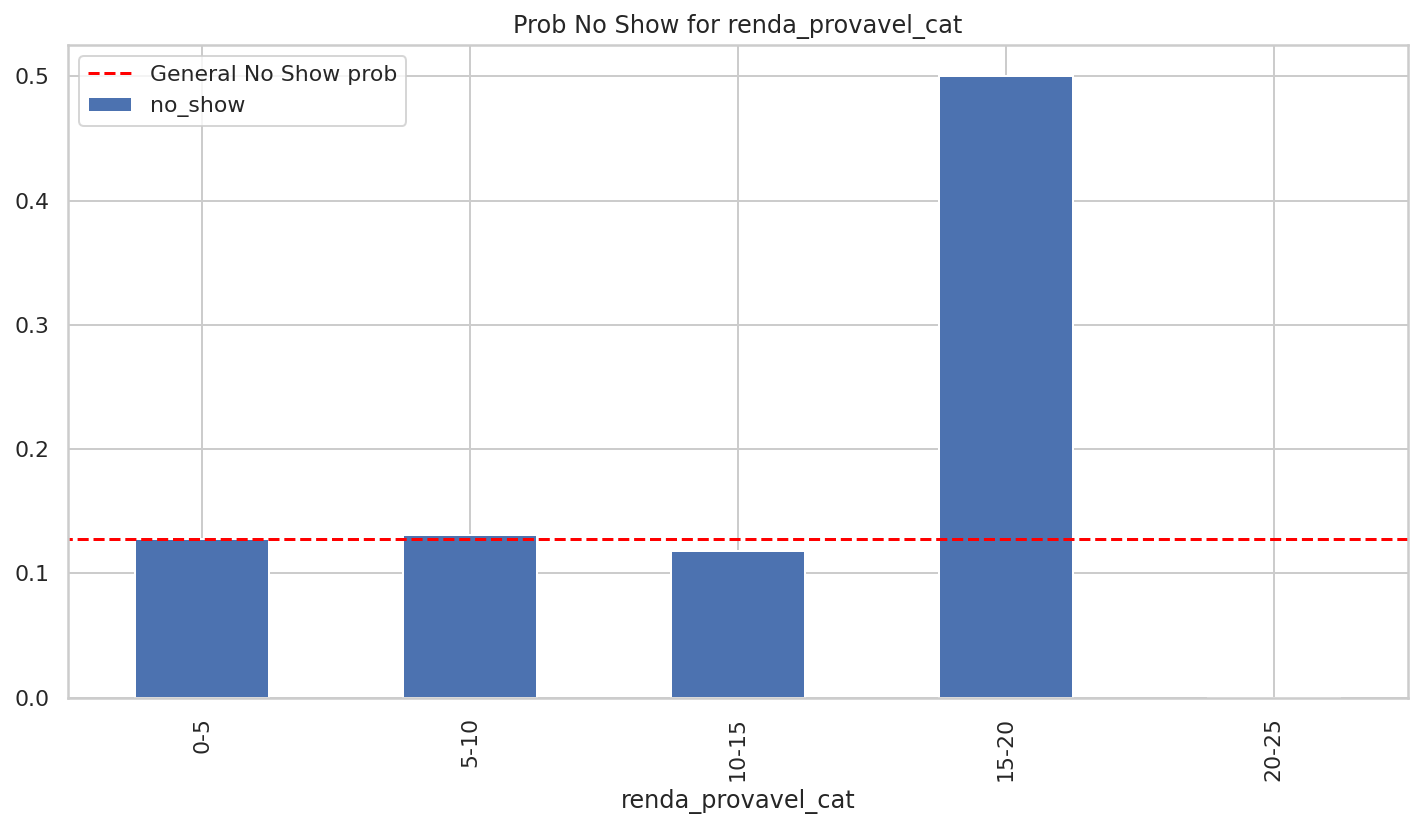

In [84]:
col = 'renda_provavel_cat'
plt.figure(figsize=(12, 6))

plot_prob_categorical(df,  col)

### redução de dimensionalidade / casos raros

In [86]:
def replace_rare(df, col, thr=0.0025):
    
    map_values = df[col].value_counts(normalize=True).to_dict()

    def replace(x):
        if map_values[x] < thr:
            return -100
        else:
            return x

    df['%s_reduced'% col] = df[col].apply(lambda x: replace(x))
    
    return df['%s_reduced'% col]
    

In [87]:
cols = ['microarea', 'codigo_exame', 'bairro', 'cod_convenio']

### Cod convenio

83 16


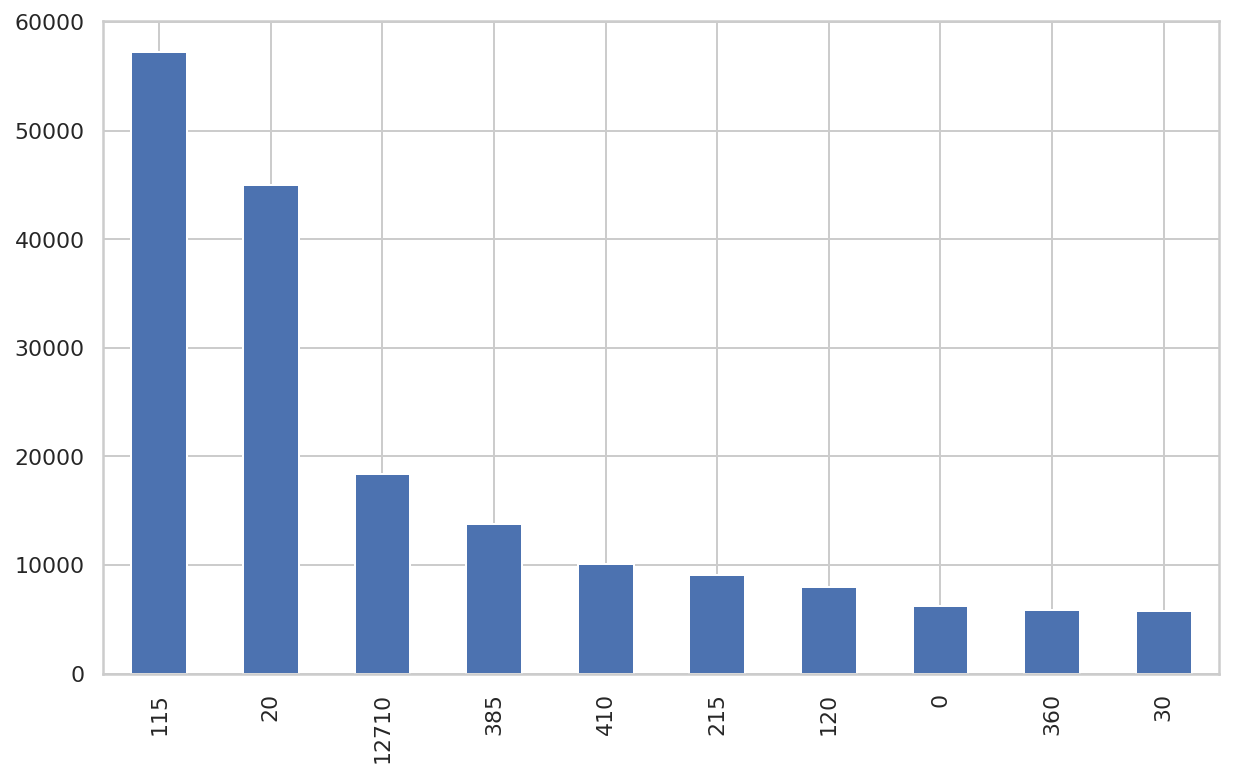

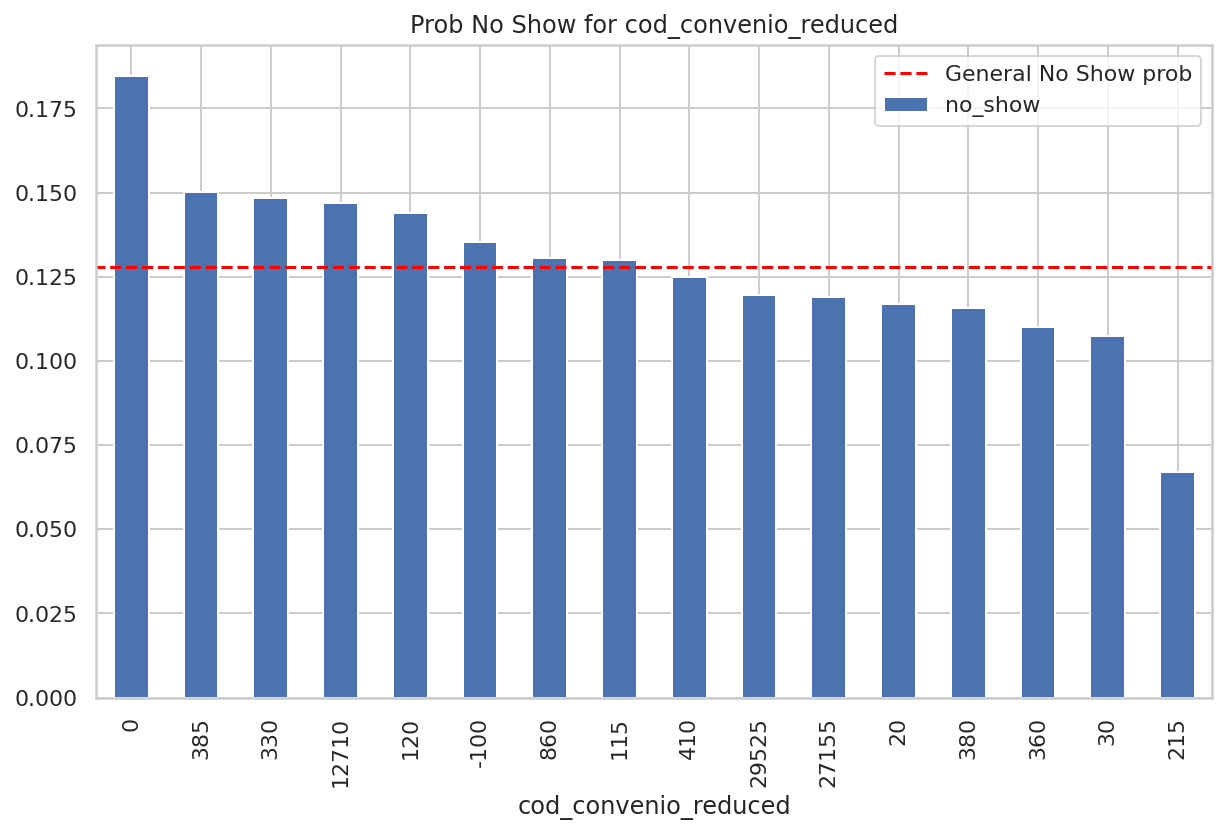

In [142]:
col = 'cod_convenio'
df['%s_reduced' % col] = replace_rare(df,col, thr=0.01)

print(len(df[col].unique()), len(df['%s_reduced' % col].unique()))

df[col].value_counts()[:10].plot(kind='bar')
plt.figure()

plot_prob_categorical(df, '%s_reduced' % col, sort=True)

### Bairro

count        21.000000
mean       9658.666667
std       29464.459481
min        2137.000000
25%        2521.000000
50%        3447.000000
75%        4016.000000
max      138209.000000
Name: bairro_reduced, dtype: float64
4278 21


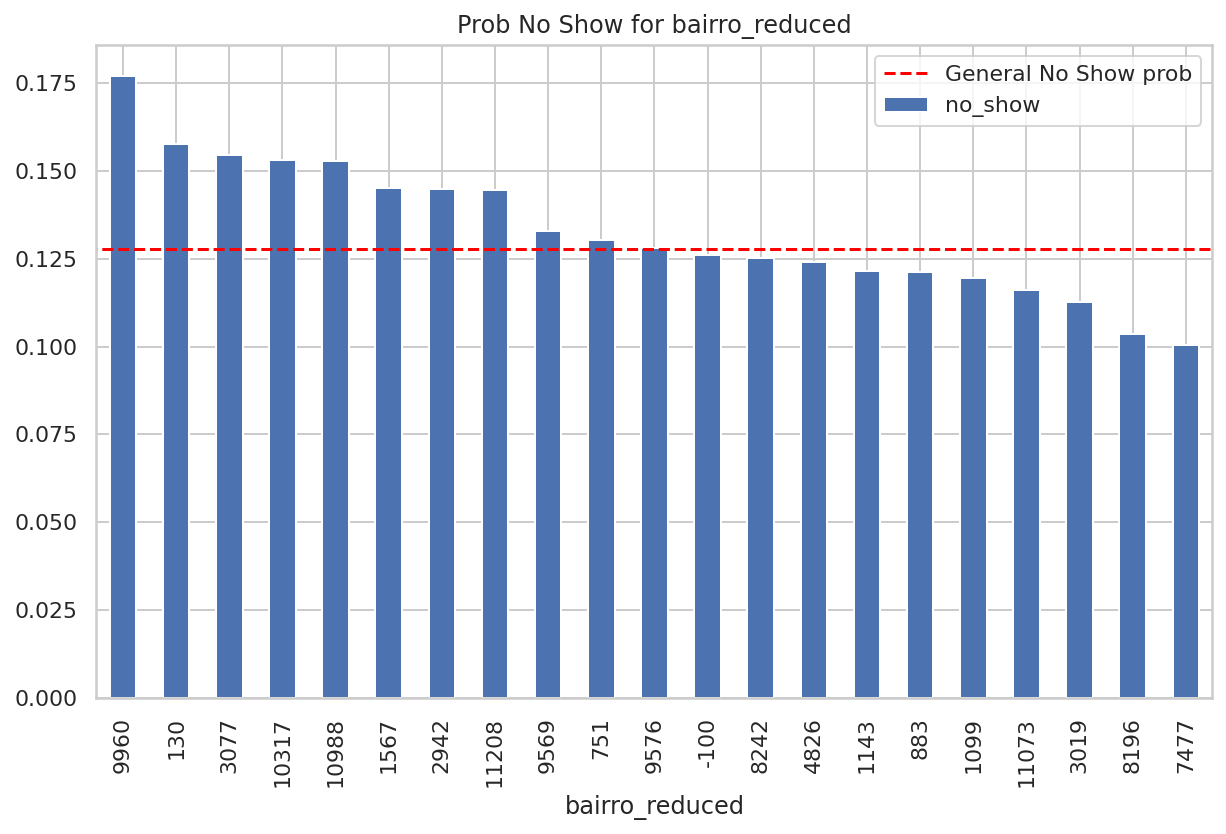

In [139]:
col = 'bairro'
df['%s_reduced' % col] = replace_rare(df,col, thr=0.01)

print(df['%s_reduced' % col].value_counts().describe())
print(len(df[col].unique()), len(df['%s_reduced' % col].unique()))

plot_prob_categorical(df, '%s_reduced' % col, sort=True)

### Codigo exame

count       23.000000
mean      8818.782609
std      11357.182489
min       2135.000000
25%       3423.000000
50%       4639.000000
75%       7838.500000
max      44471.000000
Name: codigo_exame_reduced, dtype: float64
430 23


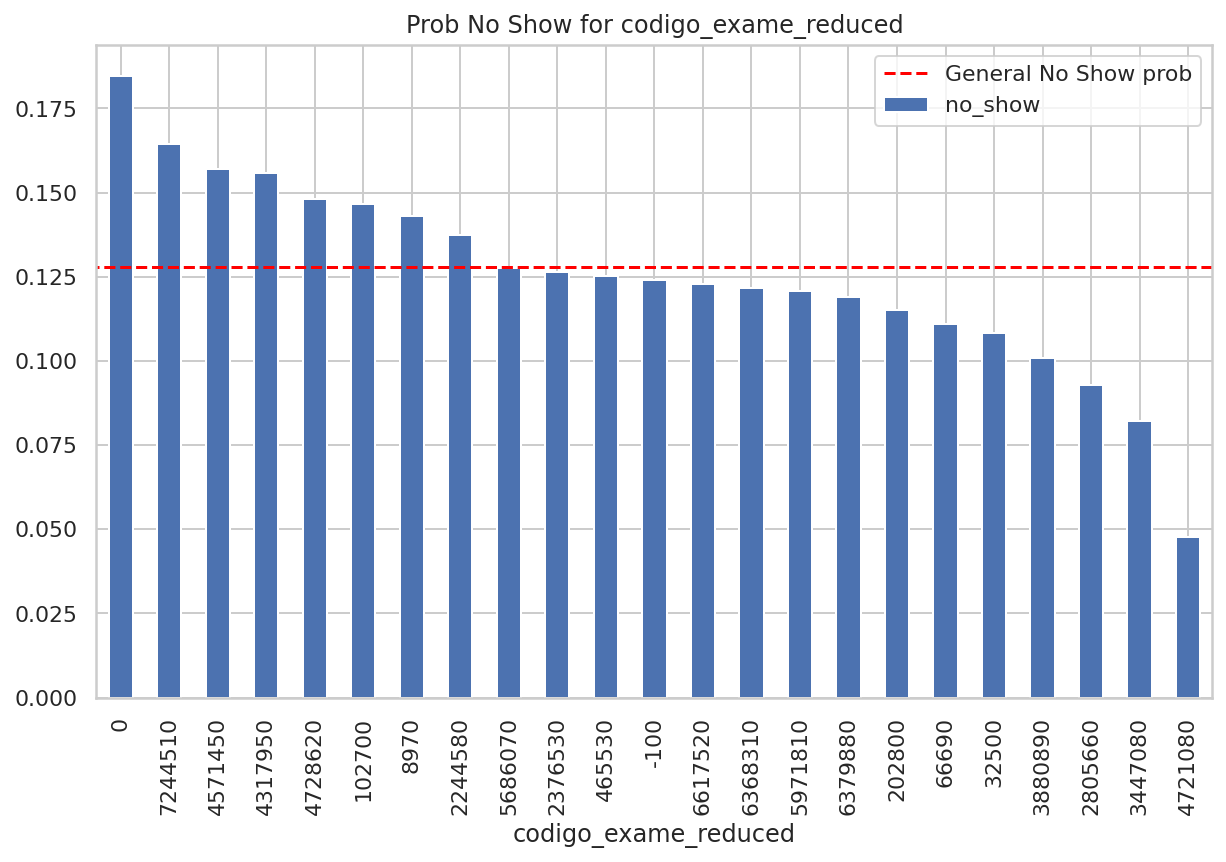

In [95]:
df['codigo_exame_reduced'] = replace_rare(df,'codigo_exame', thr=0.01)

print(df['codigo_exame_reduced'].value_counts().describe())
print(len(df['codigo_exame'].unique()), len(df['codigo_exame_reduced'].unique()))

plot_prob_categorical(df, 'codigo_exame_reduced', sort=True)

### Micro area

count       77.000000
mean      2634.181818
std       3593.887240
min        520.000000
25%        776.000000
50%       1689.000000
75%       3305.000000
max      28800.000000
Name: microarea_reduced, dtype: float64
536 77


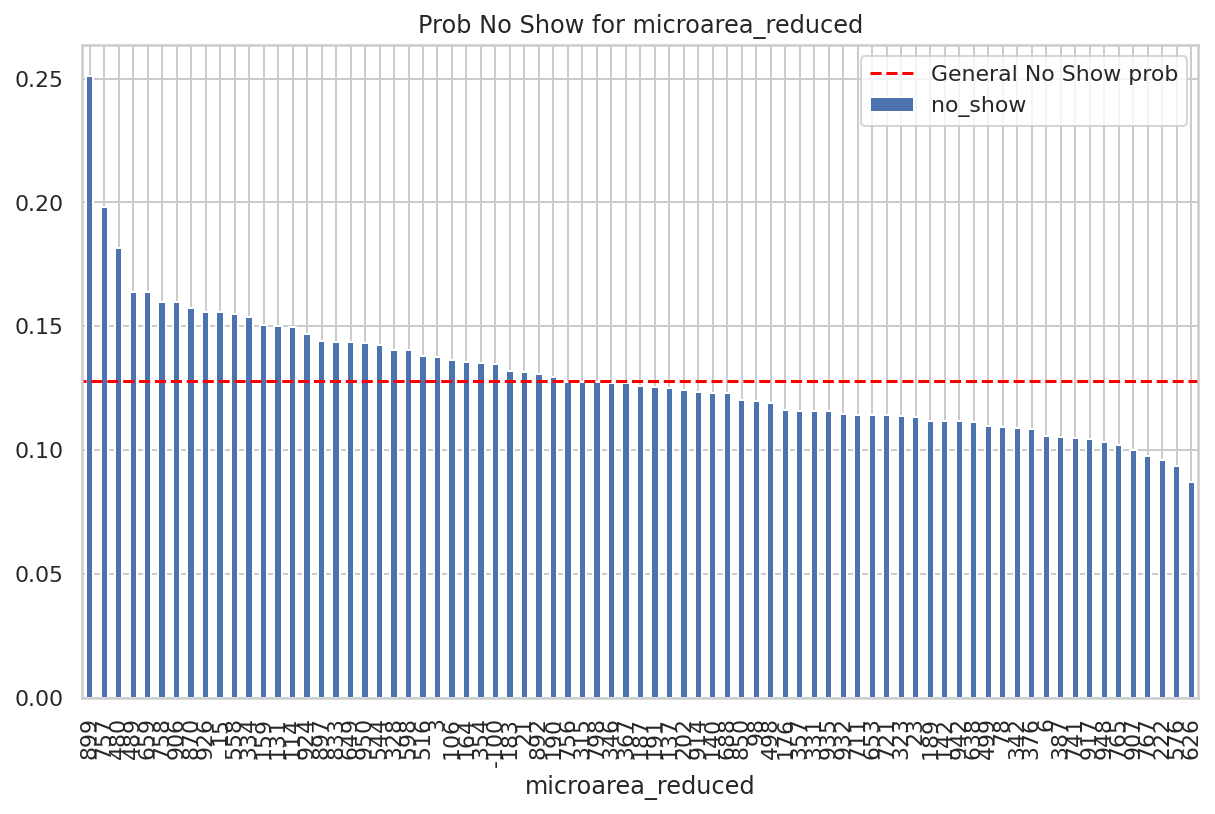

In [97]:
col = 'microarea'
df['%s_reduced' % col] = replace_rare(df,col)

print(df['%s_reduced' % col].value_counts().describe())
print(len(df[col].unique()), len(df['%s_reduced' % col].unique()))

plot_prob_categorical(df, '%s_reduced' % col, sort=True)

### Seção

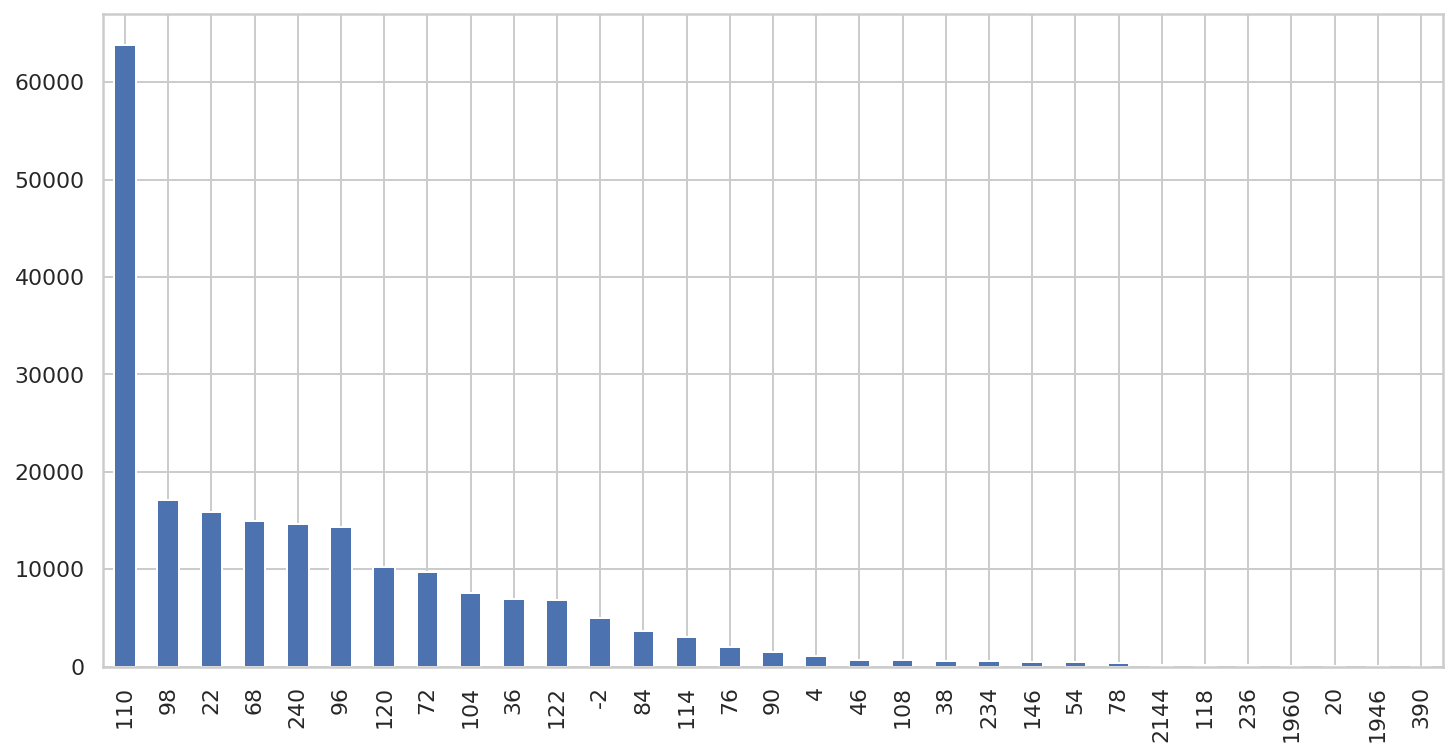

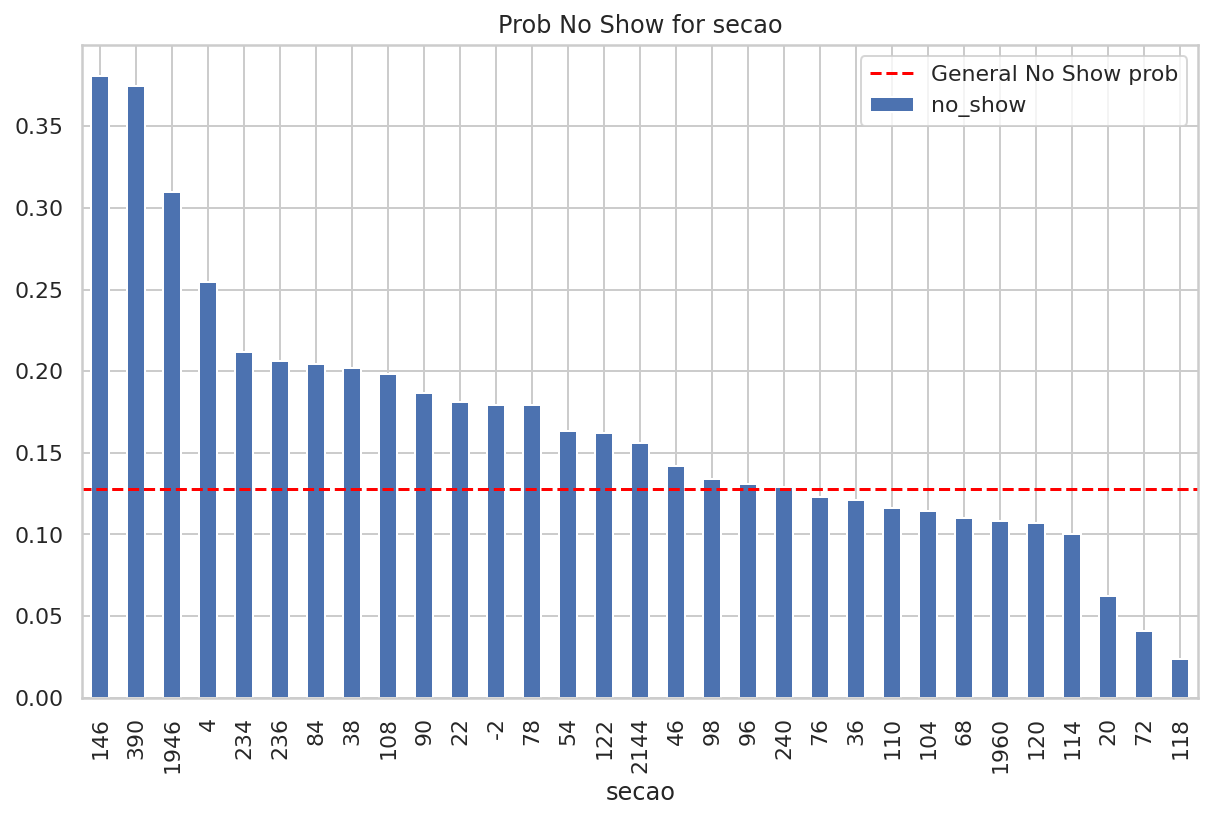

In [143]:
col = 'secao'
plt.figure(figsize=(12, 6))

chart = df.query("secao not in ('1786')")

chart['secao'].value_counts().plot(kind='bar')
plt.figure()
plot_prob_categorical(chart, col, sort=True)

### Hora atendimento

9     33944
8     32064
10    29152
7     25996
11    22591
12    11586
14     7956
13     7400
15     7305
16     6250
17     4876
18     2827
19      591
20      541
21      170
6       169
22       27
23        5
5         1
Name: hora_agendamento, dtype: int64


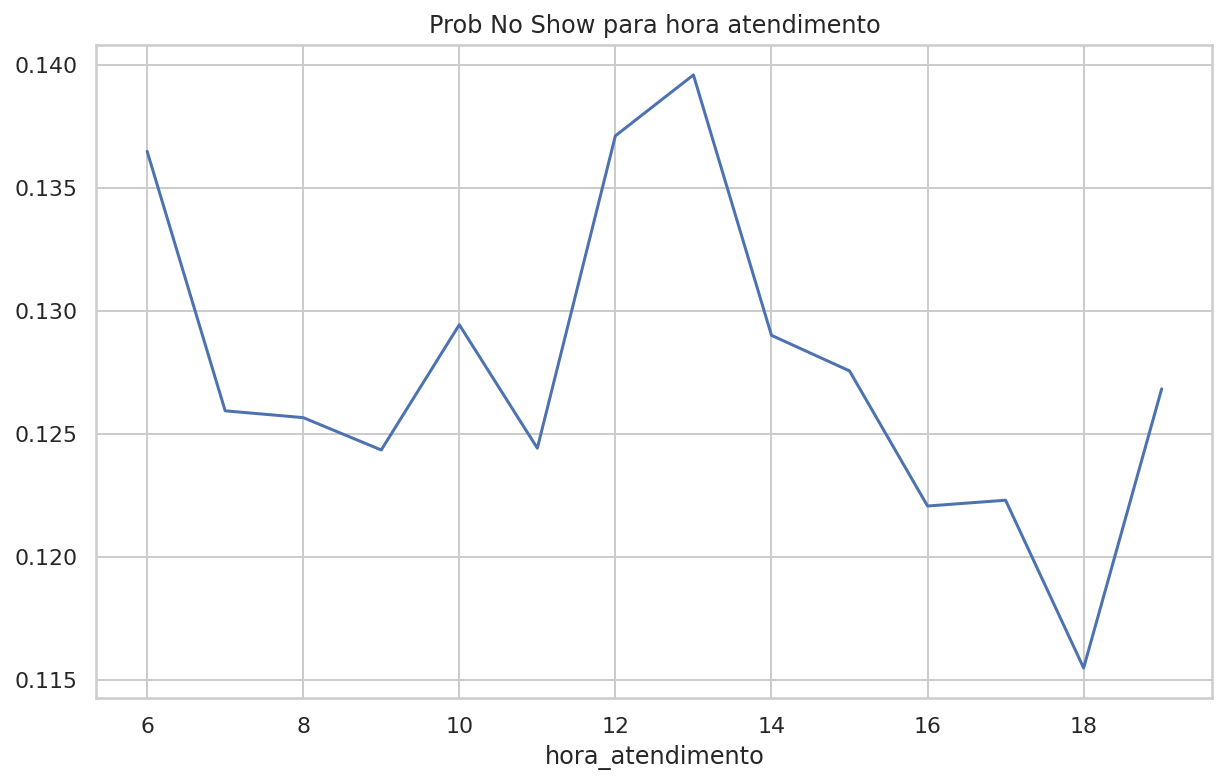

In [104]:
chart = df.query('hora_atendimento > 5')
chart = chart.query('hora_atendimento < 20')

print(chart['hora_agendamento'].value_counts())

chart.groupby('hora_atendimento')['no_show'].mean().plot()
plt.title('Prob No Show para hora atendimento');

quanto amis cedo a consulta, menor a probabilidade de No Show: 5, 6,7 e 8 hras. Horaŕios do inicio da tarde costuma ter mais chance de No Show: 12,  13, 14 e 15

Horarios tarde da noite como 22 3 23 tem menor chance de No Show

### Hora agendamento

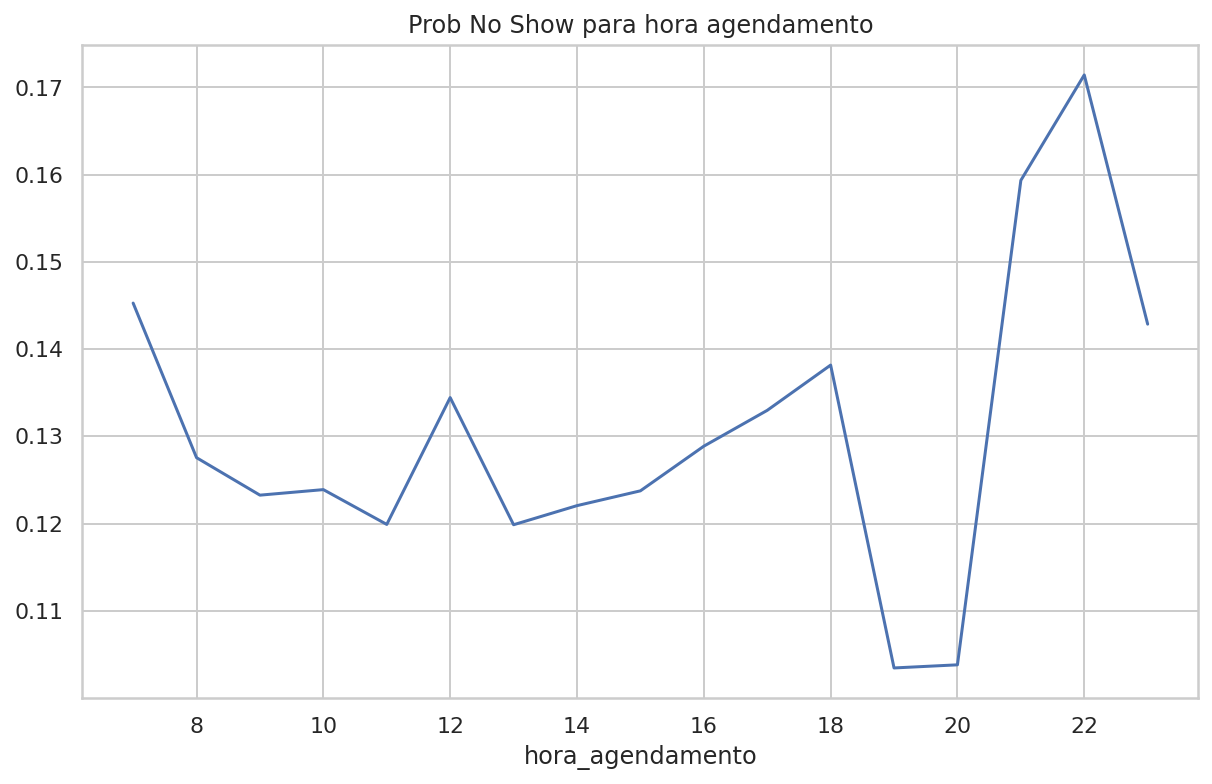

In [102]:
chart = df.query('hora_agendamento > 6')
chart.groupby('hora_agendamento')['no_show'].mean().plot();
plt.title('Prob No Show para hora agendamento');

### dia_semana_atendimento

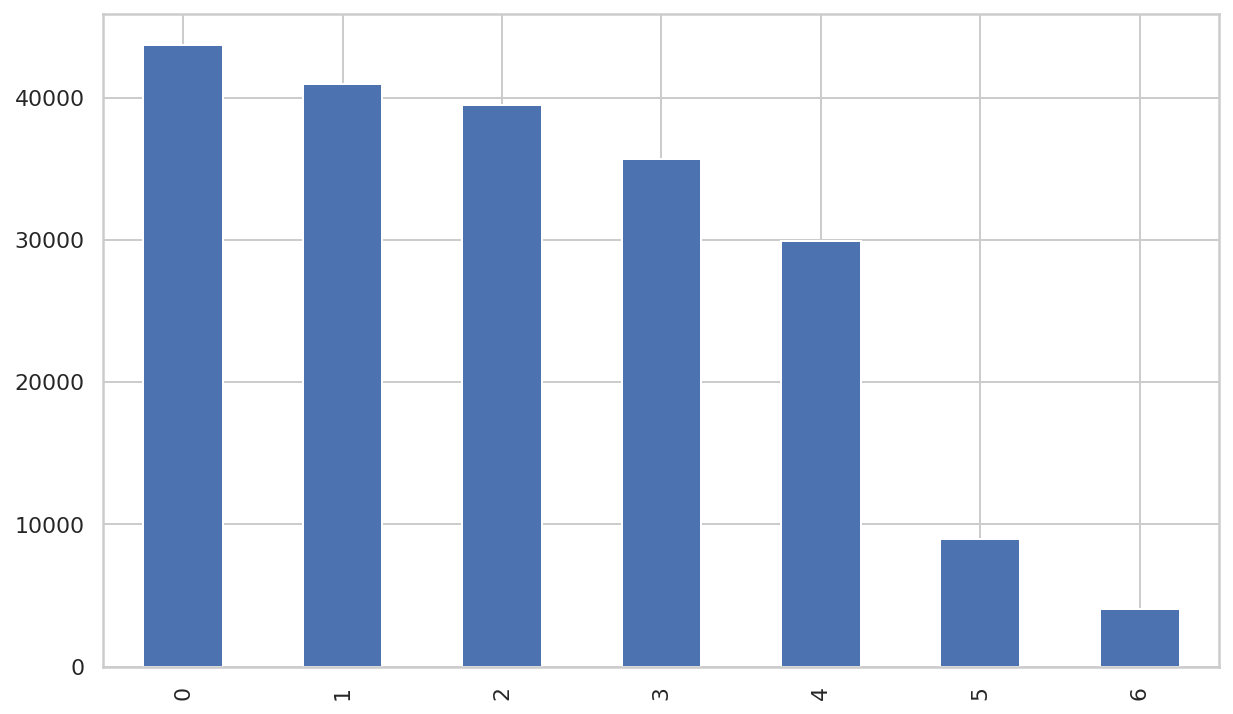

In [105]:
df['dia_semana_atendimento'].value_counts().plot(kind='bar');

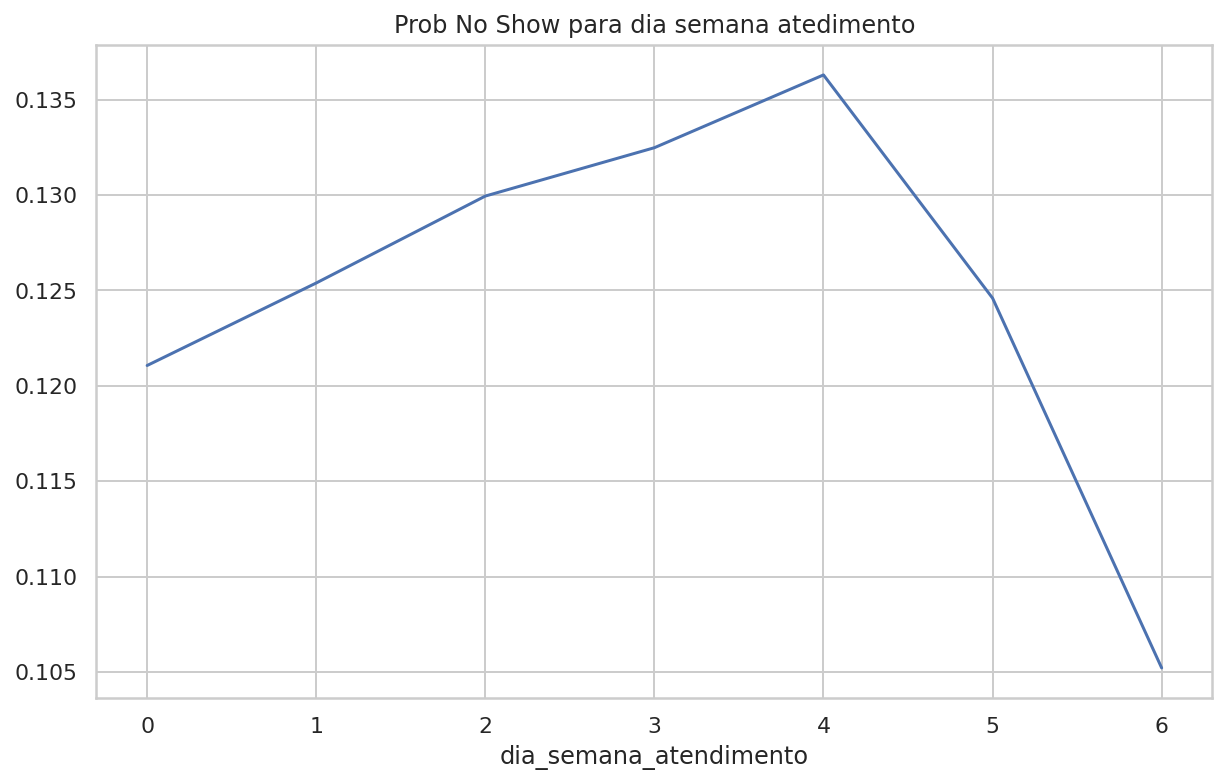

In [106]:
df.groupby('dia_semana_atendimento')['no_show'].mean().plot()
plt.title('Prob No Show para dia semana atedimento');

### Dia mes agendamento / atendimento

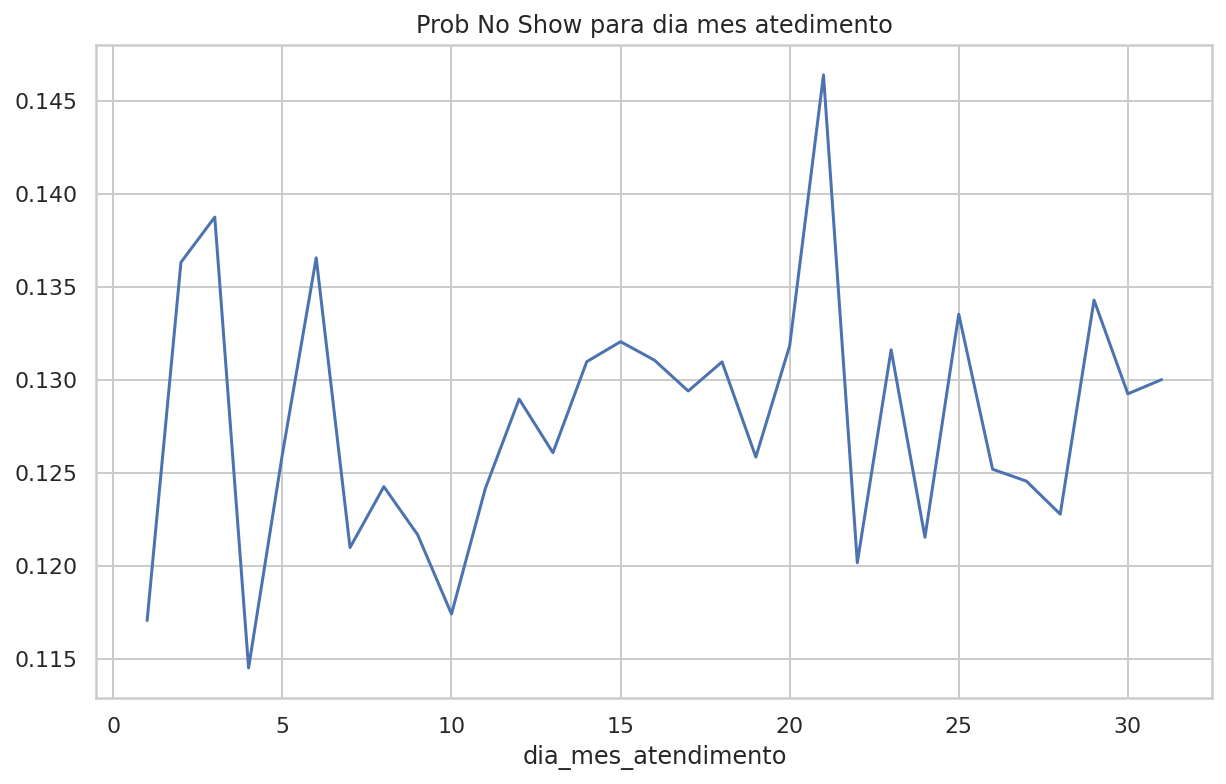

In [107]:
df.groupby('dia_mes_atendimento')['no_show'].mean().plot()
plt.title('Prob No Show para dia mes atedimento');

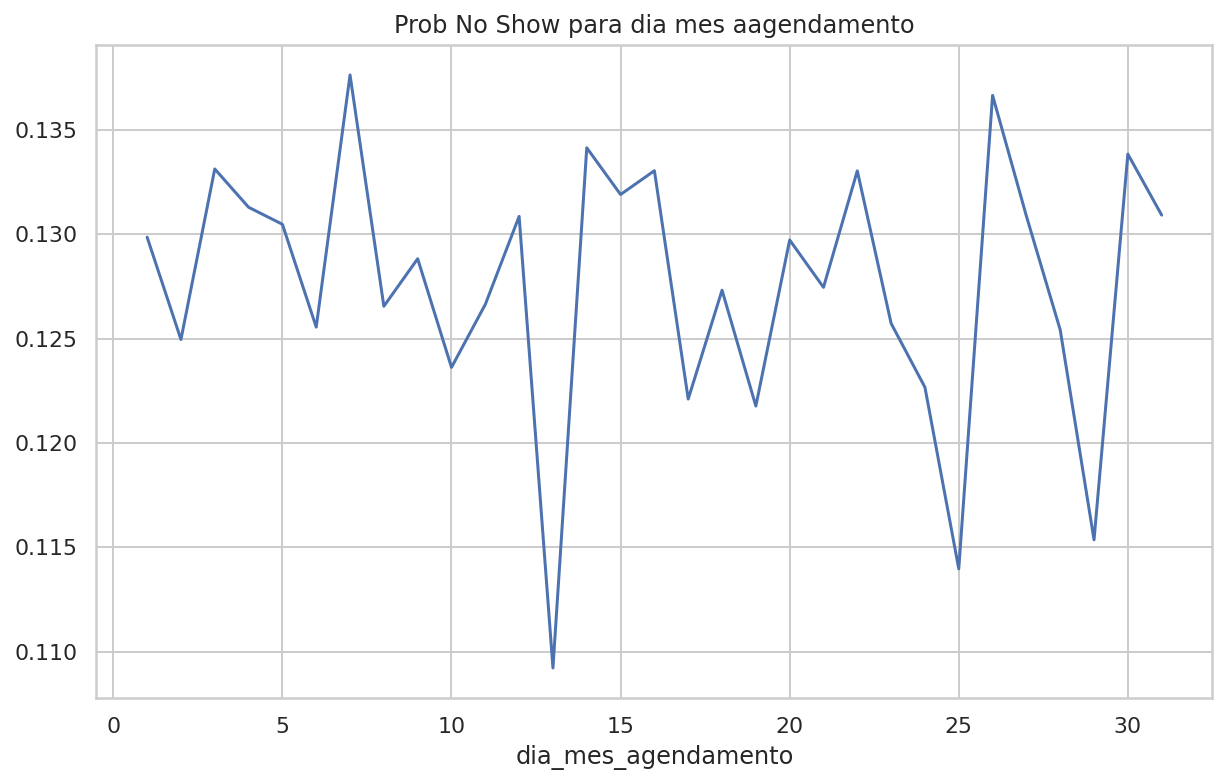

In [108]:
df.groupby('dia_mes_agendamento')['no_show'].mean().plot()
plt.title('Prob No Show para dia mes aagendamento');

### Dias até ser atendido

In [109]:
from datetime import datetime

In [110]:
df['data_atendimento'] = df.apply(lambda x:'%s-%s-%s'%(x.ano_atendimento,
                                                      x.mes_atendimento,
                                                      x.dia_mes_atendimento), axis=1)

df['data_agendamento'] = df.apply(lambda x:'%s-%s-%s'% (x.ano_agendamento,
                                                        x.mes_agendamento,
                                                        x.dia_mes_agendamento), axis=1)

df['data_agendamento'] = pd.to_datetime(df['data_agendamento'], errors='coerce')
df['data_atendimento'] = pd.to_datetime(df['data_atendimento'], errors='coerce')

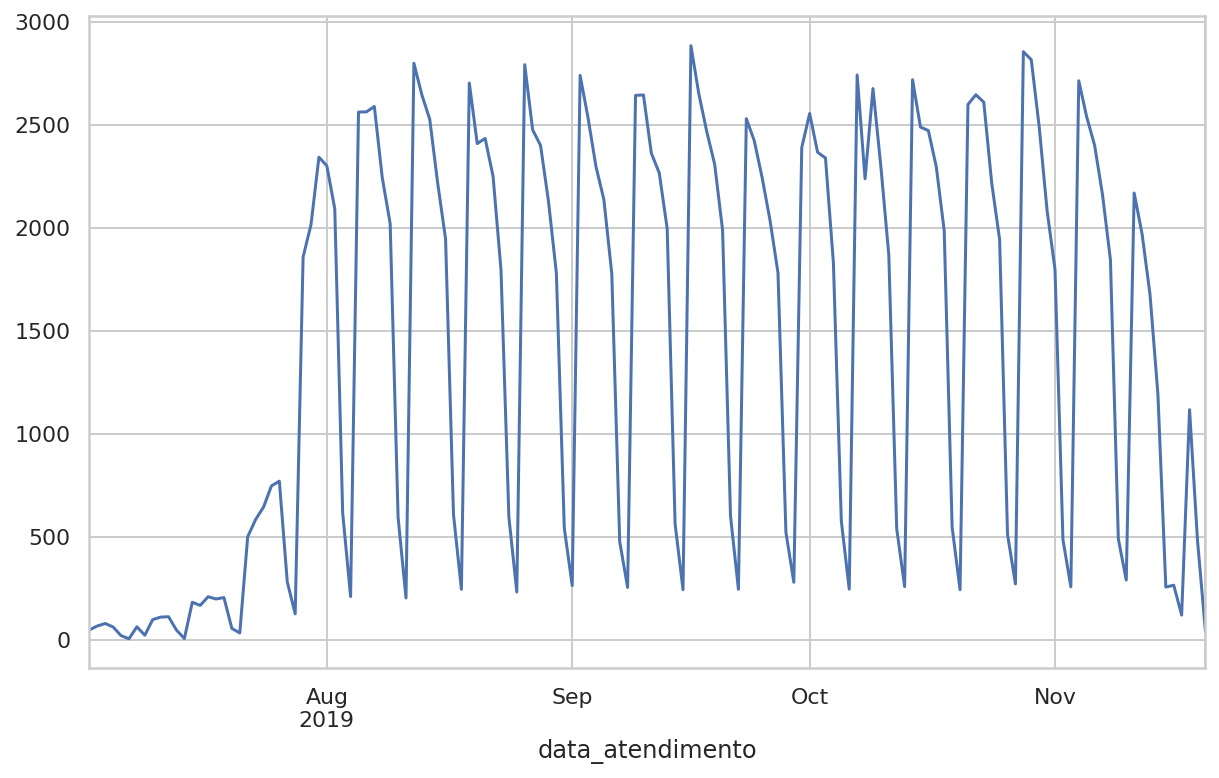

In [111]:
chart = df.sort_values(by='data_atendimento').query("data_atendimento > '2019-07-01'")

chart.groupby('data_atendimento')['secao'].count().plot();

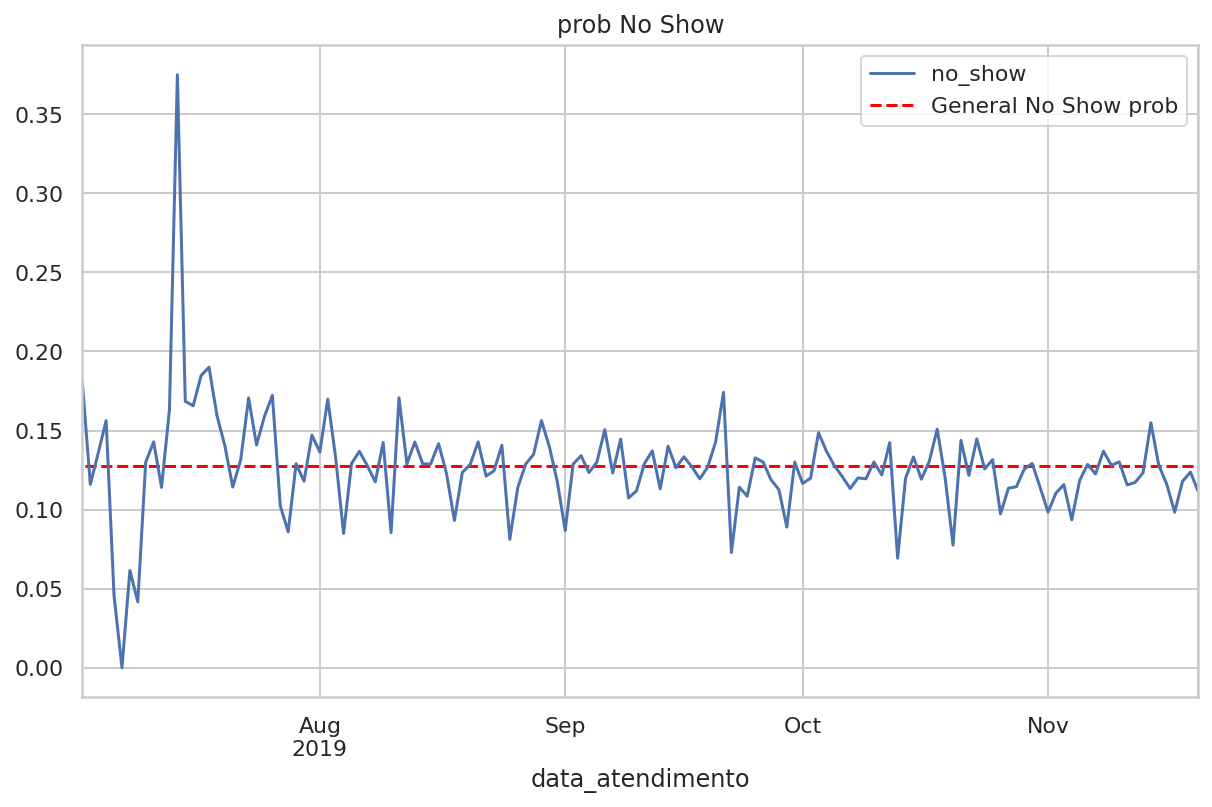

In [112]:
chart = df.sort_values(by='data_atendimento').query("data_atendimento > '2019-07-01'")

chart.groupby('data_atendimento')['no_show'].mean().plot()
plt.hlines(y=df['no_show'].mean(), xmin='2019-05', xmax='2019-12', 
           color='red', 
           linestyles='dashed', 
           label='General No Show prob')
plt.title('prob No Show')
plt.legend();

In [113]:
# insert_note('a probabilidade de No show oscila em torno de 12% ao longo do ano, sem grandes variações')

In [114]:
df['dias_ate_atendimento'] = (df['data_agendamento'] - df['data_atendimento']).dt.days

In [115]:
df['dias_ate_atendimento'].describe()

count    202832.000000
mean          7.501149
std           6.440770
min           1.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          97.000000
Name: dias_ate_atendimento, dtype: float64

In [116]:
df = df.query('dias_ate_atendimento >= 0')

In [117]:
df.query('no_show == 1')[['mes_atendimento', 'dia_mes_atendimento',
                          'mes_agendamento', 'dia_mes_agendamento', 
                          'data_atendimento', 'data_agendamento','dias_ate_atendimento', 'no_show']].sample(n=10)

,mes_atendimento,dia_mes_atendimento,mes_agendamento,dia_mes_agendamento,data_atendimento,data_agendamento,dias_ate_atendimento,no_show
260943,8,8,8,12,2019-08-08,2019-08-12,4,1
73162,9,19,9,27,2019-09-19,2019-09-27,8,1
164221,10,9,10,16,2019-10-09,2019-10-16,7,1
69213,10,23,10,31,2019-10-23,2019-10-31,8,1
228570,9,6,9,10,2019-09-06,2019-09-10,4,1
146241,8,9,8,12,2019-08-09,2019-08-12,3,1
233404,8,16,8,31,2019-08-16,2019-08-31,15,1
71505,10,11,10,13,2019-10-11,2019-10-13,2,1
156668,8,29,9,5,2019-08-29,2019-09-05,7,1
217167,8,28,8,31,2019-08-28,2019-08-31,3,1


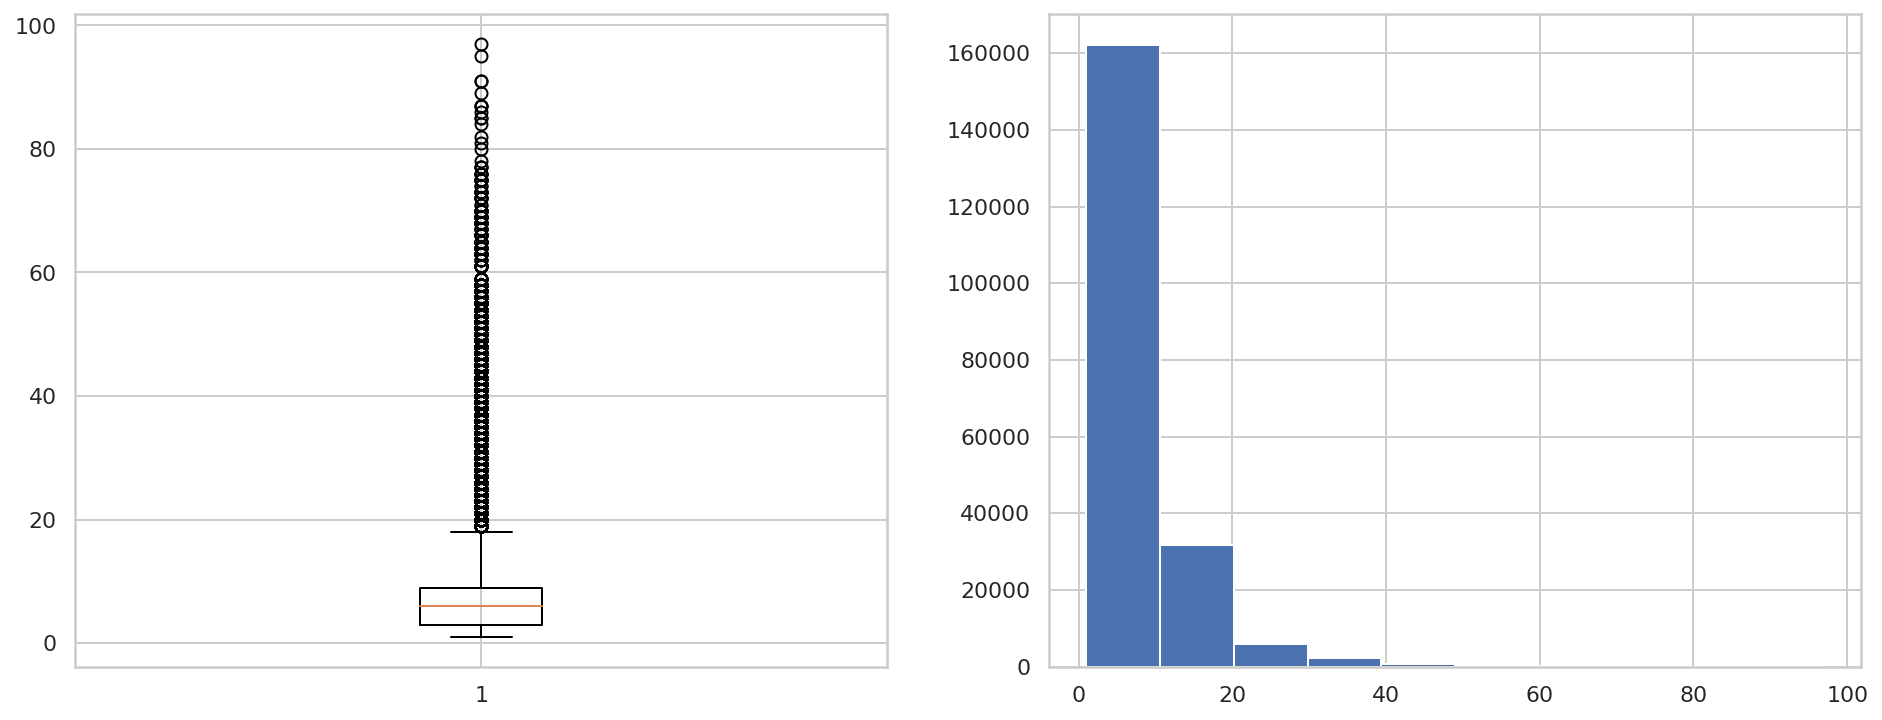

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

df['dias_ate_atendimento'].hist(ax=ax[1])
ax[0].boxplot(df['dias_ate_atendimento']);

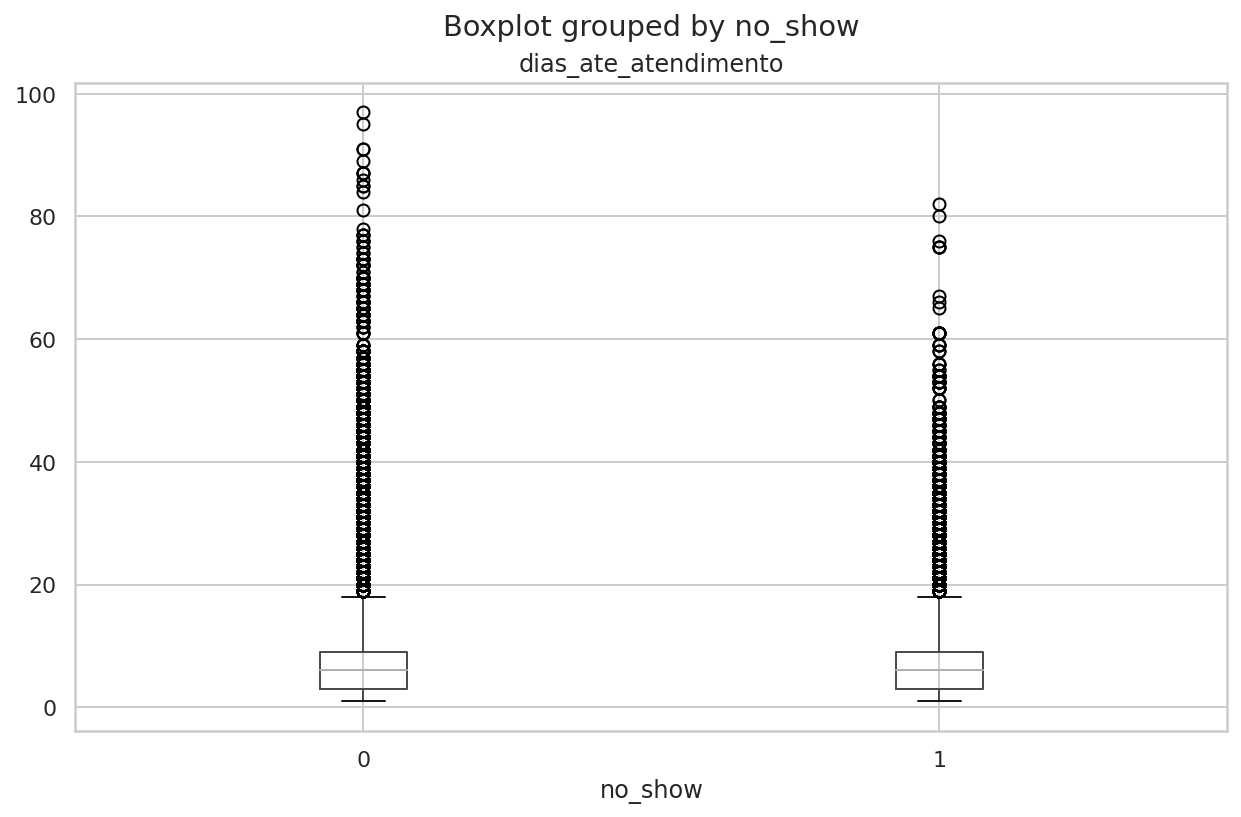

In [124]:
feature = 'dias_ate_atendimento'
chart = remove_outliers(df, feature);

chart.boxplot(column='dias_ate_atendimento', by='no_show');

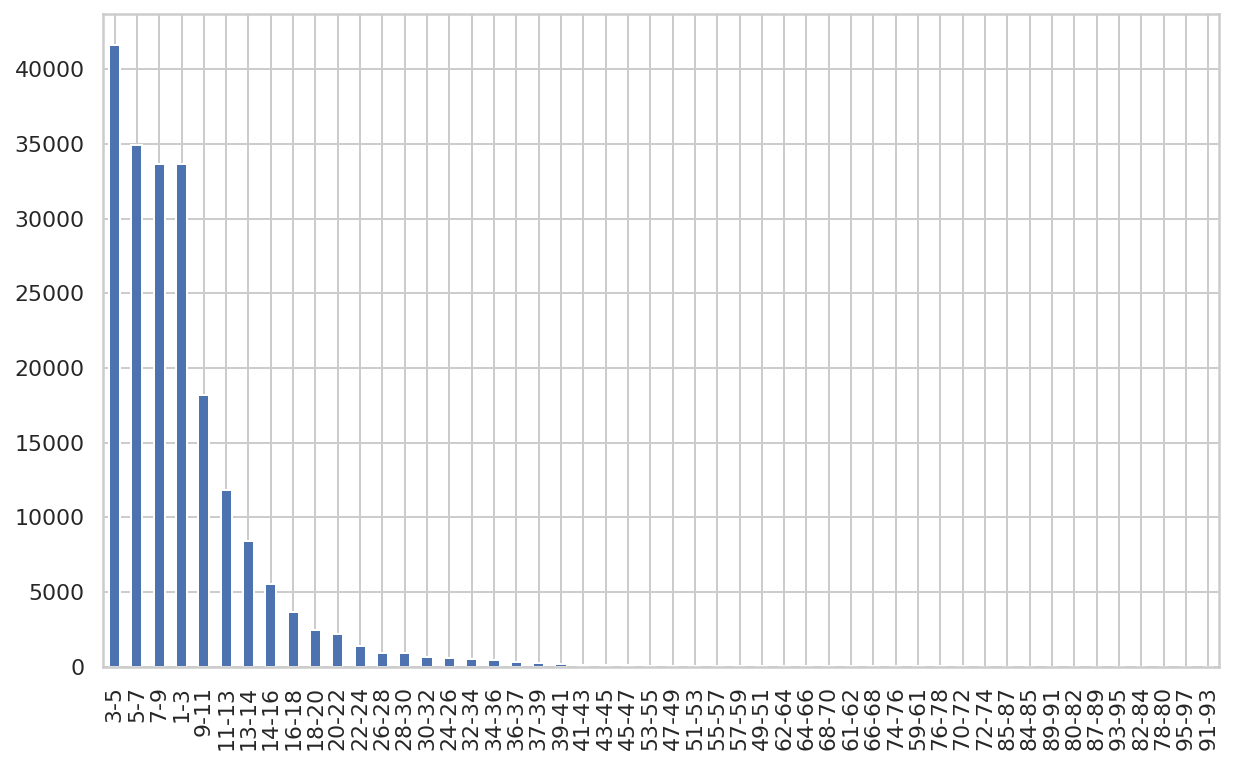

In [125]:
df['dias_ate_atendimento_cat'] = categorize_numeric(df, 'dias_ate_atendimento', n_bins=50)
df['dias_ate_atendimento_cat'].value_counts().plot(kind='bar');

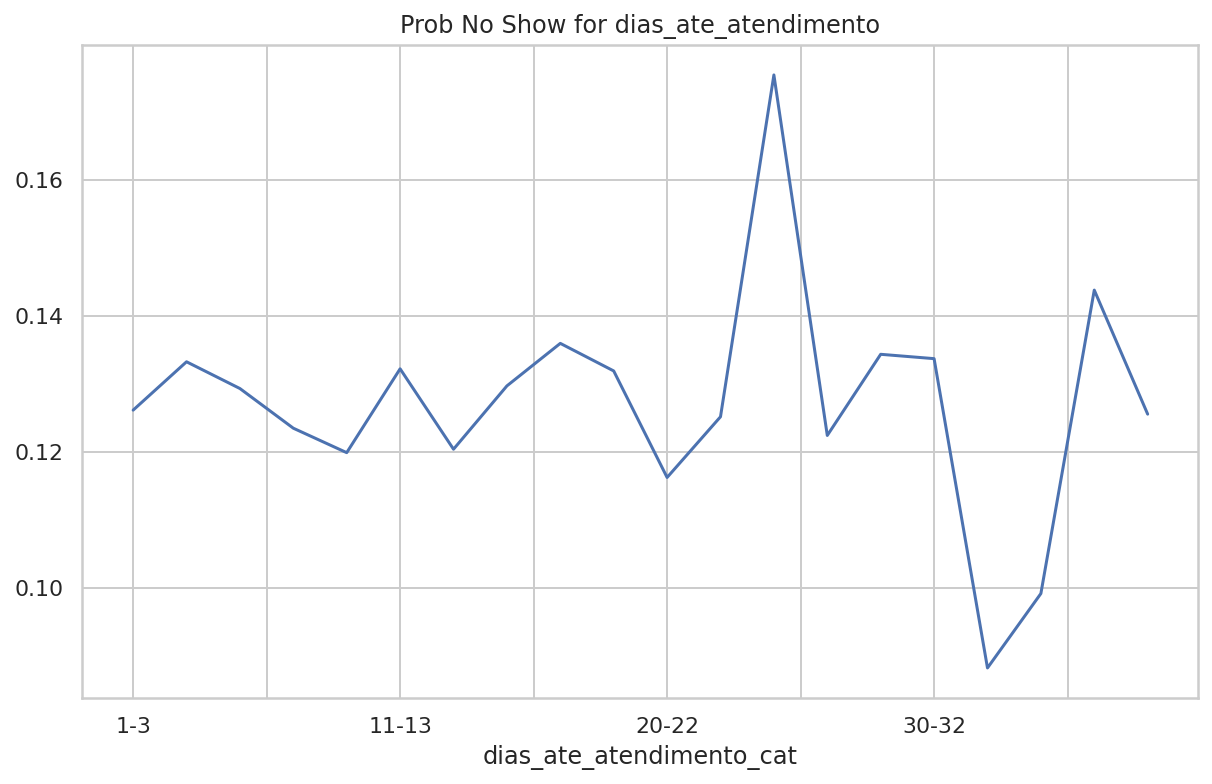

In [129]:
chart = df.query('dias_ate_atendimento < 40')
chart.groupby('dias_ate_atendimento_cat')['no_show'].mean().plot()
plt.title("Prob No Show for %s" % feature);

## Resumo

#### Quais as ações podem reduzir a ocorrência do Noshow?

As ações que podem reduzir a ocorrência de Noshow são, dar preferencia, sempre que possível para horários cedos do dia, evitando horários próximos ao meio-dia, das 9h às 15h. 

Horários noturnos após as 19h também costumam ter baixa ocorrência no NoShow.Além disso, algo que pode ajudar a diminuição de NoShow é oferecer a opção por um médico preferencial, na marcação do exame. Isso reduz drasticamente a ocorrência de NoShow.

Algo que poderia ser testado é direcionar os convênios com maior histórico de NoShow (convênio 0, por exemplo) para horários com menos chance de Noshow. O mesmo poderia ser aplicado considerando o código do exame e seção

#### Quais os principais motivos do Noshow?

Dentre os principais estão, marcação de exame para horários em torno do meio-dia.


#### Faça uma analise exploratória dos dados e comente o que você encontrou.

A taxa geral de NoShow é de 12%. Esta taxa se mantém em torno deste valor, ao longo do período analisado, com poucas oscilações. Para exames diretoria 6, a taxa de Noshow é menor. O tempo médio de agendamento parece não influenciar tanto no NoShow. A taxa de NoShow é maior dentre os mais jovens. A renda provável do paciente parece não influenciar no NoShow. Outro ponto a se considerar é que o sexo do paciente tem uma influencia bem baixa na propenção de NoShow

#### Separe os dados para treino e teste, e faça a predição de quais agendamentos serão Noshow.

Ver Jupyter notebooks dos modelos

#### Comente e explique as técnicas utilizadas (porque utilizou elas?), os insights que ajudariam o negocio a reduzir o problema de Noshow a partir da sua análise exploratória e modelagem.

Na etapa de preparação dos dados, algumas transformações foram feitas, tais como redução da cardinalidade de algumas features categóricas, como bairro, seção, codigo do exame e outros. Nestas features, os valores mais raros foram agrupados em uma única categoria. 

Após esta transformação, estas features foram codificadas, através de uma técnica chamada target-encode, através da qual, os valores, em cada feature, são substituídos para taxa de NoShow associadas a esta categoria, na feature. As variáveis categóricas de cardinalidade binária foram codificadas usando a técnica do one-hot-encode.

Dentre os algoritmos de machine learning, foram testados dois, Uma regressão logística e uma random forest. A regressão logística tem a vantagem de proporcionar uma aplicabilidade melhor e de ter uma variância menor. No entanto, apresentou um maior bias. A precisão ficou 0.18 e um recall mais alto, de 0.61.

A random forest pode ter um bias reduzido, aumentando-se a profundidade das arvores. Neste caso foi possível obter uma precisão estável (baixa variância) de 60%. No entanto, o recall ficou bem instável e baixo. Ao se usar um valor baixo na profundidade as arvores, de 8 por exemplo, as métricas deste modelo ficam mais estáveis e ligeiramente maior que a da regressão logística.

Uma técnica de grid search foi usada para identificar os melhores parâmetros para os mdoelos

#### Comente eventuais alertas sobre problemas, limitações potenciais encontradas ao longo do estudo, eventuais trade-offs, validação dos resultados obtidos e argumentos gerais sobre por que o resultado obtido é confiável.

Uma limitação observada no estado está na quantidade de dados. Para algumas variáveis, não é possível chegar a uma conclusão, pois os dados começam a ficar mais e esparsos, como é o caso da seção ou dia da semana de atendimento, por exemplo. 

Uma hipótese testada, foi se o numero de dias desde o agendamento até o atendimento influencia no NoShow. Esta variável parece não ser um forte preditor, mas isso pode ter ocorrido por falta de dados suficientes.Durante a modelagem, a curva de aprendizagem mostrou que o modelo não se beneficiaria de mais dados, mas acredito que mais dados poderiam melhorar a análise das variáveis em si.

Os modelos treinados possuem alguns trade-offs. A regressão logística provê uma capacidade de interpretabilidade maior ao custo de um maior bias, aĺém de ser mais estável. Já a random forest, por ser mais flexivel, possui um bias bem menor se trabalhado com arvores mais profundas, ao custo de uma menor explicabilidade e um pouco mais de variância no recall.
 